# DAQA: Extended analysis

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This analysis will answer the following questions...

**For the whole data set:**
- what % of projects have addresses?
- what % of projects have completion dates?
- what % of projects have associated firms but no architects?
- what % of projects have associated architects but no firms?
- what % of firms have ‘operating years’ recorded

**Number of projects:**
- Before 1940
- Between 1940-1980
- Post 1980
- Undated

**For the 40-80 data set:**
- what % of projects have addresses?
- what % of projects have completion dates? 
- what % of projects have associated firms but no architects?
- what % of projects have associated architects but no firms?
- what % of firms have ‘operating years’ recorded

**Analytic questions:**
- Which architects were associated with Queensland governement projects i.e., Brisbane City Council, Department of Works, etc.?
- Which architects have registrations recorded in DAQA between 1940-1980?
- UQ vs (BCTC, QIT, QUT) vs the rest for whole data, 1940-1980, and also 1940 to present.
- Repeat ‘how many completed related to a person’. 1940-1980 and the Pareto distribution
- Number completed projects 1940-80
- Number of works by year, most active vs rest 1940-1980
- what % of the different typologies 1940-1980
- Number of works by year by typology
- what % of projects extant/demolished/modified 1940-1980
- average and mean number of employers of the DAQA interviewed architects
- names of Architects associated with the highest number of projects 1940-1980
- names of firms associated with the highest number of projects 1940-1980
- names of top 5 Architects associated with the highest number of each typology 1940-1980
- names of top 5  firms associated with the highest number of projects 1940-1980
- what % of architects who are women associated with projects 1940-1980
- what % of architects who are women associated with projects after 1980
- 5 Firms with the longest timespan with the same name.
- 5 Firms with the longest timespan with successive names/known predecessor firms.

In [1]:
import requests, gzip, io, os, json

# for data mgmt
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import ast

# for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.colors import to_rgba
import plotly.express as px

# for hypothesis testing
from scipy.stats import chi2_contingency
from scipy.stats import pareto

import warnings
warnings.filterwarnings("ignore")

# provide folder_name which contains uncompressed data i.e., csv and jsonl files
# only need to change this if you have already downloaded data
# otherwise data will be fetched from google drive
global folder_name
folder_name = 'data/local'

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    return pd.read_csv(io.StringIO(rawdata))

def check_if_csv_exists_in_folder(filename):
    try: return pd.read_csv(os.path.join(folder_name, filename), low_memory=False)
    except: return None

def fetch_data(filetype='csv', acdedata='organization'):
    filename = f'acde_{acdedata}_202307131040.{filetype}'

    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(filename)
    if data_from_path is not None: return data_from_path

    urls = fetch_small_data_from_github('acde_data_gdrive_urls.csv')
    sharelink = urls[urls.data == acdedata][filetype].values[0]
    url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    response = requests.get(url)
    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

def fetch_all_DAQA_data():
    daqa_data_dict = dict()
    for entity in ['event', 'organization', 'person', 'place', 'recognition', 'resource', 'work']:
        daqa_this_entity = fetch_data(acdedata=entity)
        daqa_data_dict[entity] = daqa_this_entity[daqa_this_entity.data_source.str.contains('DAQA')]
    return daqa_data_dict

df_daqa_dict = fetch_all_DAQA_data() # 1 min if data is already downloaded
daqa_work = df_daqa_dict['work']
daqa_persons = df_daqa_dict['person']
daqa_orgs = df_daqa_dict['organization']
daqa_resources = df_daqa_dict['resource']

## High-level summary of DAQA entities

Before we jump into the analysis in response to the questions above, let's take a look at a high-level of each DAQA entity i.e., `person`, `organisation`, `work`, `resource`. 

Each entity has a `class` and we provide the count for each class for a given entity along with the total count of all classes. Next we output a count of all relationships between entities, and to this end, we generate detailled counts for all class-level relationships for each entity.

In [3]:
# architects
print('Total number of persons:', daqa_persons.shape[0])
architect_count = daqa_persons['longterm_roles'].value_counts().reset_index()
architect_count['Proportion'] = round(architect_count['longterm_roles']/architect_count['longterm_roles'].sum(),3)
architect_count['Type'] = np.where(architect_count['index'].str.contains('non-architect'), 'non-architect', 'architect')
display(architect_count\
        .groupby('Type')\
        .sum()\
        .reset_index()\
        .rename(columns={'longterm_roles':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# firms
print('\nTotal number of organisations:', daqa_orgs.shape[0])
firm_count = daqa_orgs['_class_ori'].value_counts().reset_index()
firm_count['Proportion'] = round(firm_count['_class_ori']/firm_count['_class_ori'].sum(),3)
display(firm_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# projects
print('\nTotal number of works i.e, projects:', daqa_work.shape[0])
project_count = daqa_work['_class_ori'].value_counts().reset_index()
project_count['Proportion'] = round(project_count['_class_ori']/project_count['_class_ori'].sum(),3)
display(project_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# articles
print('\nTotal number of resources i.e., articles, interviews:', daqa_resources.shape[0])
article_count = daqa_resources['_class_ori'].value_counts().reset_index()
article_count['Proportion'] = round(article_count['_class_ori']/article_count['_class_ori'].sum(),3)
display(article_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

Total number of persons: 1103


,Frequency,Proportion
Type,,
architect,912,0.827
non-architect,191,0.173



Total number of organisations: 967


,Frequency,Proportion
Type,,
"""firm""",907,0.938
"""education""",39,0.040
"""organisation""",15,0.016
"""government""",6,0.006



Total number of works i.e, projects: 2203


,Frequency,Proportion
Type,,
"""structure""",2203,1.0



Total number of resources i.e., articles, interviews: 7696


,Frequency,Proportion
Type,,
"""Photograph""",3784,0.492
"""LineDrawing""",1102,0.143
"""article""",783,0.102
"""Image""",742,0.096
"""Article""",686,0.089
"""Audio""",142,0.018
"""Transcript""",128,0.017
"""Portrait""",102,0.013
"""interview""",92,0.012


In [4]:
relationship_cols = daqa_persons.iloc[:, 62:].columns
relevant_datasets = df_daqa_dict.keys()

relations = []
for this_df in relevant_datasets:
    for idx,row in df_daqa_dict[this_df].iterrows():
        for col in relationship_cols:
            try: 
                if isinstance(row[col], str): relations.append(pd.json_normalize(ast.literal_eval(row[col])))
            except: continue

relations = pd.concat(relations)
relations = relations.drop_duplicates()

# replace person with specfic role
# create dictionary of architects and their ids
arch_nonarch_dict = daqa_persons[['ori_id','longterm_roles']]
arch_nonarch_dict['_class_ori'] = np.where(arch_nonarch_dict['longterm_roles'].str.contains('non-architect'), 'non-architect', 'architect')
arch_nonarch_dict = arch_nonarch_dict.drop('longterm_roles', axis=1).set_index('ori_id').to_dict()['_class_ori']

relations['subject.ori_id'] = relations['subject.ori_id'].astype(str)
relations['object.ori_id'] = relations['object.ori_id'].astype(str)

relations['subject._class_ori'] = np.where(relations['subject._class'] == 'person', 
                                       relations['subject.ori_id'].map(arch_nonarch_dict), 
                                       relations['subject._class_ori'])
relations['object._class_ori'] = np.where(relations['object._class'] == 'person', 
                                       relations['object.ori_id'].map(arch_nonarch_dict), 
                                       relations['object._class_ori'])

# relations
print('Total number of relationships:', relations.shape[0])
display(relations.relation_class.value_counts()\
        .reset_index()\
        .rename(columns={'index':'relation_class','relation_class':'Frequency'})\
        .assign(Proportion = lambda x: round(x['Frequency']/x['Frequency'].sum(),3))\
        .set_index('relation_class')
        .sort_values('Frequency', ascending=False))

# predicate terms
print('\nTotal number of unique predicates', relations['predicate.term'].nunique())
display(relations['predicate.term'].value_counts()\
        .reset_index()\
        .rename(columns={'index':'predicate.term','predicate.term':'Frequency'})\
        .assign(Proportion = lambda x: round(x['Frequency']/x['Frequency'].sum(),3))\
        .set_index('predicate.term')
        .sort_values('Frequency', ascending=False))

Total number of relationships: 17451


,Frequency,Proportion
relation_class,,
Work_RelatedResource,4889,0.280
Person_RelatedWork,2313,0.133
Person_RelatedPerson,1952,0.112
Work_RelatedPlace,1843,0.106
Person_RelatedOrganization,1568,0.090
Organization_RelatedWork,1484,0.085
Resource_RelatedResource,924,0.053
Person_RelatedResource,671,0.038
Resource_RelatedPerson,610,0.035



Total number of unique predicates 33


,Frequency,Proportion
predicate.term,,
HasMedia,6300,0.361
WorkedOn,3502,0.201
LocatedIn,1843,0.106
Employment,1289,0.074
Reference,1188,0.068
RelatedTo,636,0.036
WorkedWith,402,0.023
TaughtBy,357,0.020
InfluencedBy,244,0.014


In [5]:
def fetch_relation_details(relation_types, relations=relations):
    this_relation = relations[relations['relation_class'].isin(relation_types)].fillna('-')
    print(f'Total number of {relation_types[0].replace("Related","").replace("_","-")} relations:', this_relation.shape[0])
    display(this_relation[['subject._class_ori','object._class_ori','predicate.term']]\
        .value_counts()\
        .reset_index()\
        .rename(columns={0:'Frequency'})\
        .sort_values('Frequency', ascending=False))

print('###################### PERSON RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Person_RelatedWork','Work_RelatedPerson'])
print('\n')
fetch_relation_details(['Person_RelatedPerson'])
print('\n')
fetch_relation_details(['Person_RelatedOrganization','Organization_RelatedPerson'])
print('\n')
fetch_relation_details(['Person_RelatedResource','Resource_RelatedPerson'])
print('\n')
fetch_relation_details(['Person_RelatedRecognition'])
print('\n')
fetch_relation_details(['Person_RelatedPlace'])
print('\n')

print('###################### WORK RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Work_RelatedResource','Resource_RelatedWork'])
print('\n')
fetch_relation_details(['Work_RelatedPlace'])
print('\n')
fetch_relation_details(['Work_RelatedRecognition'])
print('\n')

print('###################### ORGANISATION RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Organization_RelatedWork','Work_RelatedOrganization'])
print('\n')
fetch_relation_details(['Organization_RelatedOrganization'])
print('\n')
fetch_relation_details(['Recognition_RelatedOrganization'])

print('###################### RESOURCE RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Resource_RelatedResource'])
print('\n')
fetch_relation_details(['Resource_RelatedOrganization','Organization_RelatedResource'])
print('\n')
fetch_relation_details(['Resource_RelatedPlace'])
print('\n')
fetch_relation_details(['Resource_RelatedRecognition'])
print('\n')

###################### PERSON RELATIONSHIPS ######################


Total number of Person-Work relations: 2344


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,structure,WorkedOn,2157
1,architect,structure,Reference,97
2,structure,architect,DesignedBy,30
3,architect,structure,InfluencedBy,20
4,architect,structure,StudiedAt,8
5,architect,structure,Employment,7
6,architect,structure,TravelledTo,6
7,architect,structure,TaughtAt,4
9,architect,structure,Attended,3
8,architect,structure,RelatedTo,3




Total number of Person-Person relations: 1952


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,architect,WorkedWith,359
1,architect,architect,TaughtBy,323
2,architect,architect,Reference,219
3,architect,architect,StudiedWith,210
4,architect,architect,InfluencedBy,192
5,architect,architect,KnewSocially,171
6,architect,architect,Employment,97
7,architect,architect,KnewProfessionally,97
8,architect,architect,KnewOf,36
9,architect,non-architect,KnewProfessionally,32




Total number of Person-Organization relations: 1575


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,firm,Employment,1137
1,architect,education,StudiedAt,108
2,architect,firm,PartnerOf,75
3,architect,firm,Reference,55
4,architect,education,Employment,35
5,architect,firm,InfluencedBy,19
6,architect,firm,Founded,15
7,architect,firm,WorkedWith,14
8,architect,firm,TaughtBy,10
9,architect,firm,CollaboratedWith,9




Total number of Person-Resource relations: 1281


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,architect,Reference,364
1,architect,Photograph,HasMedia,257
2,architect,interview,IsInvolvedIn,91
3,interview,architect,RelatedTo,86
4,non-architect,interview,RelatedTo,86
5,interview,non-architect,RelatedTo,85
6,architect,interview,RelatedTo,82
7,architect,Image,HasMedia,80
8,interview,non-architect,Reference,75
9,architect,Portrait,HasMedia,66




Total number of Person-Recognition relations: 60


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,award,Awarded,20
1,architect,award,TravelledTo,15
2,architect,award,Reference,8
3,architect,award,Became,5
4,architect,award,Authored,3
5,architect,award,Attended,2
6,architect,award,Read,2
7,architect,award,RelatedTo,1
8,architect,award,WasInfluenceBy,1
9,architect,award,WorkedWith,1




Total number of Person-Place relations: 7


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,place,TravelledTo,5
1,architect,place,Reference,1
2,architect,place,RelatedTo,1




###################### WORK RELATIONSHIPS ######################


Total number of Work-Resource relations: 4979


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,structure,Photograph,HasMedia,3143
1,structure,LineDrawing,HasMedia,1088
2,structure,Image,HasMedia,651
3,interview,structure,Reference,90
4,structure,Portrait,HasMedia,7




Total number of Work-Place relations: 1843


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,structure,place,LocatedIn,1843




Total number of Work-Recognition relations: 1


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,structure,award,Awarded,1




###################### ORGANISATION RELATIONSHIPS ######################


Total number of Organization-Work relations: 1661


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,firm,structure,WorkedOn,1343
1,structure,firm,RelatedTo,144
2,firm,structure,RelatedTo,141
3,structure,firm,DesignedBy,33




Total number of Organization-Organization relations: 420


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,firm,firm,PrecededBy,221
1,firm,firm,succeededby,189
2,firm,firm,MergedWith,4
3,firm,firm,CollaboratedWith,2
4,firm,firm,WorkedWith,2
5,firm,firm,Became,1
6,government,firm,ClientOf,1




Total number of Recognition-Organization relations: 1


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,award,education,StudiedAt,1


###################### RESOURCE RELATIONSHIPS ######################


Total number of Resource-Resource relations: 924


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,article,Article,HasMedia,646
1,interview,Audio,HasMedia,127
2,interview,Transcript,HasMedia,83
3,interview,Youtube,HasMedia,45
4,interview,Video,HasMedia,22
5,interview,publication,Reference,1




Total number of Resource-Organization relations: 278


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,education,Reference,121
1,interview,firm,Reference,68
2,firm,Photograph,HasMedia,57
3,firm,Image,HasMedia,15
4,firm,Portrait,HasMedia,9
5,interview,organisation,Reference,6
6,firm,LineDrawing,HasMedia,2




Total number of Resource-Place relations: 77


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,place,DoneIn,77




Total number of Resource-Recognition relations: 48


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,award,Reference,48


## Projects & firms

Below are some statistics about project characteristics and firms in the DAQA dataset. Proportions under the `PROJECTS` subheading are calculated as a percentage of the total number of projects in the dataset. Proportions under the `FIRMS` subheading are calculated as a percentage of the total number of firms in the dataset.

It should be noted that all people related to projects are architects, we found no non-architects in the project records. Also all organisations related to projects are firms, we found no non-firm organisations in the project records.

- We define a project with an address as one that has a populated `address` field
- We define a project with a geocode date as one that has a populated `longitude` and `latitude` field
- We define a project with a completion date as one that has a populated `completion year` field
- We define a project with an associated firm as one that has a populated `related_organizations` field
- We define a project with no associated firms as one that has a no populated `related organizations` field
- We define a project with an associated architect as one that has a populated `related_people` field
- We define a project with no associated architects as one that has no populated `related_people` field
- We define a firm with operating years as an organisation that has a populated `operation` field

In [6]:
print('###################### PROJECTS ######################')

# load data
daqa_work = df_daqa_dict['work']

print('\nQ: How many projects are recorded in DAQA?')
count_projects = len(daqa_work)
print(f'A: There are {count_projects} projects in DAQA.')

# we define a project with an address as one that has a populated "address" field
print('\nQ: what % of projects have addresses?')
count_projects_with_address = len(daqa_work[daqa_work.coverage_range.apply(lambda x: "address" in x)])
prop_projects_with_address = round((count_projects_with_address / count_projects) * 100, 2)
print(f'A: {prop_projects_with_address}% ({count_projects_with_address}) of DAQA projects have addresses.')

# we define a project with a geocode date as one that has a populated "longitude" field
print('\nQ: what % of projects have geocodes (lat/long)?')
count_projects_with_geocodes = len(daqa_work[daqa_work.coverage_range.apply(lambda x: "latitude" in x)])
prop_projects_with_geocodes = round((count_projects_with_geocodes / count_projects) * 100, 2)
print(f'A: {prop_projects_with_geocodes}% ({count_projects_with_geocodes}) of DAQA projects have geocodes.')

# we define a project with a completion date as one that has a populated "completion year" field
print('\nQ: what % of projects have completion dates?')
count_projects_with_completion_dates = len(daqa_work[daqa_work.coverage_range.apply(lambda x: "date_end" in x)])
prop_projects_with_completion_dates = round((count_projects_with_completion_dates / count_projects) * 100, 2)
print(f'A: {prop_projects_with_completion_dates}% ({count_projects_with_completion_dates}) of DAQA projects have completion dates.')

# we conduct a sanity check to see if related people in daqa_work are all architects, we find no non-architects
# # load data
# daqa_persons = df_daqa_dict['person']
# non_architects = daqa_persons[daqa_persons['longterm_roles'].str.contains('non-architect')]['ori_id'].unique()
# len(daqa_work[daqa_work.related_people.apply(lambda x: pd.json_normalize(eval(x))['subject.ori_id'].values[0] in non_architects if isinstance(x, str) else False)])

# we conduct a sanity check to see if related organisations in daqa_work are all firms, we find no non-firms
# count_related_organizations_firms = len(daqa_work[daqa_work.related_organizations.apply(lambda x: "firm" in x if isinstance(x, str) else False)])
# count_related_organizations = len(daqa_work[daqa_work.related_organizations.notnull()])
# count_related_organizations_firms == count_related_organizations

# we define a project with an associated firm as one that has a populated "related_organizations" field
print('\nQ: how many projects have associated firms?')
count_projects_with_firms = len(daqa_work[daqa_work.related_organizations.notnull()])
prop_projects_with_firms = round((count_projects_with_firms / count_projects) * 100, 2)
print(f'A: {prop_projects_with_firms}% ({count_projects_with_firms}) of DAQA projects have associated firms.')

# we define a project with no associated architects as one that has no populated "related_people" field
print('\nQ: what % of projects have associated firms but no architects?')
count_projects_with_firms_no_architects = len(daqa_work[(daqa_work.related_organizations.notnull()) &\
                                                        (daqa_work.related_people.isnull())])
prop_projects_with_firms_no_architects = round((count_projects_with_firms_no_architects / count_projects) * 100, 2)
print(f'A: {prop_projects_with_firms_no_architects}% ({count_projects_with_firms_no_architects}) of DAQA projects have associated firms but no architects.')

# we define a project with an associated architect as one that has a populated "related_people" field
print('\nQ: how many projects have associated architects?')
count_projects_with_architects = len(daqa_work[daqa_work.related_people.notnull()])
prop_projects_with_architects = round((count_projects_with_architects / count_projects) * 100, 2)
print(f'A: {prop_projects_with_architects}% ({count_projects_with_architects}) of DAQA projects have associated architects.')

# we define a project with an associated architects as one that has a populated "related people" field
# and we define a project with no associated firms as one that has a no populated "related organizations" field
print('\nQ: what % of projects have associated architects but no firms?')
count_projects_with_architects_no_firms = len(daqa_work[(daqa_work.related_organizations.isnull()) &\
                                                        (daqa_work.related_people.notnull())])
prop_projects_with_architects_no_firms = round((count_projects_with_architects_no_firms / count_projects) * 100, 2)
print(f'A: {prop_projects_with_architects_no_firms}% ({count_projects_with_architects_no_firms}) of DAQA projects have associated architects but no firms.')

print('\n###################### FIRMS ######################')

# load data
daqa_orgs = df_daqa_dict['organization']
daqa_firms = daqa_orgs[daqa_orgs['_class_ori'].str.contains('firm')].copy()

print('\nQ: How many firms are recorded in DAQA?')
count_firms = len(daqa_firms)
print(f'A: There are {count_firms} firms in DAQA.')

# we define an operating firm as an organisation that has a populated "operation" field with a start date
print('\nQ: what % of firms have ‘operating years’ recorded (just start)?')
count_firms_with_operating_start = len(daqa_firms[daqa_firms.operation.apply(lambda x: "date_start" in x if isinstance(x, str) else False)])
prop_firms_with_operating_start = round((count_firms_with_operating_start / count_firms) * 100, 2)
print(f'A: {prop_firms_with_operating_start}% ({count_firms_with_operating_start}) of DAQA firms have operating years recorded.')

# we define an operating firm as an organisation that has a populated "operation" field with start and end dates
print('\nQ: what % of firms have ‘operating years’ recorded (start and end)?')
count_firms_with_operating_years = len(daqa_firms[daqa_firms.operation.apply(lambda x: ("date_start" in x) & ("date_end" in x) if isinstance(x, str) else False)])
prop_firms_with_operating_years = round((count_firms_with_operating_years / count_firms) * 100, 2)
print(f'A: {prop_firms_with_operating_years}% ({count_firms_with_operating_years}) of DAQA firms have operating years recorded.')

# top 5 firms - longest timespan 
daqa_firms_with_op_yrs = daqa_firms[daqa_firms.operation.apply(lambda x: "date_start" in x if isinstance(x, str) else False)]

# extract the start and end years from the "operation" field
start_dates = []; end_dates = []

for index, row in daqa_firms_with_op_yrs.iterrows():
    start_dates.append(int(pd.json_normalize(ast.literal_eval(row['operation']))['date_start.year'].values[0]))

    try: end_dates.append(int(pd.json_normalize(ast.literal_eval(row['operation']))['date_end.year'].values[0]))
    except: end_dates.append(None)

daqa_firms_with_op_yrs['start_yr'] = start_dates
daqa_firms_with_op_yrs['end_yr'] = end_dates
daqa_firms_with_op_yrs['diff'] = abs(daqa_firms_with_op_yrs['end_yr'] - daqa_firms_with_op_yrs['start_yr'])

print('\nQ: What are the top five firms with the longest timespan with the same name? (must have operating start and end years)')
display(daqa_firms_with_op_yrs.sort_values(by='diff', ascending=False)\
    .head(5)[['primary_name', 'start_yr', 'end_yr', 'diff']])

###################### PROJECTS ######################

Q: How many projects are recorded in DAQA?
A: There are 2203 projects in DAQA.

Q: what % of projects have addresses?
A: 84.29% (1857) of DAQA projects have addresses.

Q: what % of projects have geocodes (lat/long)?
A: 65.68% (1447) of DAQA projects have geocodes.

Q: what % of projects have completion dates?
A: 60.37% (1330) of DAQA projects have completion dates.

Q: how many projects have associated firms?
A: 58.87% (1297) of DAQA projects have associated firms.

Q: what % of projects have associated firms but no architects?
A: 14.21% (313) of DAQA projects have associated firms but no architects.

Q: how many projects have associated architects?
A: 81.03% (1785) of DAQA projects have associated architects.

Q: what % of projects have associated architects but no firms?
A: 36.36% (801) of DAQA projects have associated architects but no firms.

###################### FIRMS ######################

Q: How many firms are recorded 

,primary_name,start_yr,end_yr,diff
21223,"""Evans Deakin & Company (Engineers & Shipbuild...",1910,1980.0,70.0
21594,"""Bates Smart & McCutcheon""",1926,1995.0,69.0
21165,"""Brown and Broad LTD""",1905,1967.0,62.0
20909,"""Queensland Housing Commission""",1945,2004.0,59.0
21164,"""George Brockwell Gill Architect and Agent""",1889,1943.0,54.0


### Top five firms with the longest timespan with successive names/known predecessor firms.

We inspect the top five firms with the longest timespan with successive names/known predecessor firms. We use network graphs to visualise the predecessor/successor relationships between firms. The graphs are interactive, so you can click on the nodes to see the firm names and the years they were active.

In [7]:
daqa_firms_with_related_orgs = daqa_firms[daqa_firms.related_organizations.notnull()]

related_orgs_df = pd.DataFrame()

for index, row in daqa_firms_with_related_orgs.iterrows():
    this_row_id = int(row['ori_id'])
    this_org_related = pd.json_normalize(ast.literal_eval(row['related_organizations']))
    related_orgs_df = related_orgs_df.append(this_org_related)

related_orgs_df.drop_duplicates(inplace=True)
related_orgs_df = related_orgs_df[related_orgs_df['predicate.term'].isin(['succeededby', 'PrecededBy','MergedWith'])]
related_orgs_ls = related_orgs_df[['subject.ori_id','object.ori_id']].values.tolist()

def get_connected_nodes(snapshot):
    connected_nodes = []
    for node_list in snapshot:
        connected_node_set = set(node_list)
        for connected_node in connected_nodes:
            if connected_node & connected_node_set:
                connected_node |= connected_node_set
                break
        else:
            connected_nodes.append(connected_node_set)
    
    connected_node_lists = [list(connected_node) for connected_node in connected_nodes]
    return connected_node_lists

connected_node_lists = get_connected_nodes(related_orgs_ls)
connected_node_lists = get_connected_nodes(connected_node_lists)
connected_node_lists = get_connected_nodes(connected_node_lists)

first_date = []
last_date = []

for nodes in connected_node_lists[0:]:
    this_nodes = daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int).isin(nodes)]
    all_dates = this_nodes['start_yr'].to_list()
    all_dates.extend(this_nodes['start_yr'].to_list())

    if len(all_dates) > 0:
        first_date.append(min(all_dates))
        last_date.append(max(all_dates))

    else:
        first_date.append(None)
        last_date.append(None)


# dates
dts = pd.DataFrame([first_date, last_date]).T

# add nodes as column
dts.columns = ['first_date', 'last_date']
dts['nodes'] = connected_node_lists
dts['diff'] = dts['last_date'] - dts['first_date']

display(dts.sort_values(by='diff', ascending=False).head(5))

,first_date,last_date,nodes,diff
61,1862,1967,"[4795, 3838, 3846]",105
4,1893,1995,"[2310, 2446, 2447, 2449, 4628, 2456, 2338, 502...",102
2,1864,1963,"[5033, 2387, 2356, 2457, 4890, 4891, 4892, 4286]",99
17,1926,2010,"[4576, 2497, 3868, 2440, 4459, 4460, 2445, 446...",84
28,1938,2002,"[2336, 4994, 2501, 4511, 2413, 2478, 4527, 363...",64


</br>Firm 1 (105 years)

In [8]:
def output_graph(data, iteration = 0):
    import networkx as nx
    from pyvis import network as net

    g = net.Network(notebook=True, 
                    height='500px',
                    width="100%",
                    cdn_resources = 'remote', 
                    select_menu=True)
    
    df = related_orgs_df[related_orgs_df['subject.ori_id']\
                    .isin(dts.sort_values(by='diff', ascending=False)\
                        .iloc[iteration]['nodes'])][['subject.label','object.label','predicate.term']]

    dd = daqa_firms_with_op_yrs.copy()
    dd['primary_name'] = dd['primary_name'].apply(lambda x: ast.literal_eval(x))

    # Iterate over each row in the dataset
    for _, row in df.iterrows():
        subject = row['subject.label']
        predicate = row['predicate.term']
        obj = row['object.label']
        
        try:
            sub_start = dd[dd['primary_name'].str.contains(subject)]['start_yr'].values[0]
            sub_end = dd[dd['primary_name'].str.contains(subject)]['end_yr'].values[0]
        except:
            sub_start = None
            sub_end = None

        try:
            obj_start = dd[dd['primary_name'].str.contains(obj)]['start_yr'].values[0]
            obj_end = dd[dd['primary_name'].str.contains(obj)]['end_yr'].values[0]
        except:
            obj_start = None
            obj_end = None

        g.add_node(subject, subject, title=f"{subject} \nStart: {sub_start} \nEnd: {sub_end}", color='blue')
        g.add_node(obj, obj, title=f"{obj} \nStart: {obj_start} \nEnd: {obj_end}", color='blue')

        # Add edges to the graph based on the relationship type
        if predicate == 'succeededby':
            g.add_edge(subject, obj, color='red', title=predicate, arrows='to')
        elif predicate == 'PrecededBy':
            g.add_edge(obj, subject, color='red', title='succeededby', arrows='to')
        elif predicate == 'MergedWith':
            g.add_edge(subject, obj, color='green', title=predicate, width=3)
            g.add_edge(obj, subject, color='green', title=predicate, width=3)

    var_options = """var_options = {
                    "nodes": {"font": {"size": 12}},
                    "interaction": {"hover": "True"}}
                """

    g.set_options(var_options)
    return g

display(daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int)\
                       .isin(dts.sort_values(by='diff', ascending=False)\
                             .iloc[0]['nodes'])][['primary_name','ori_id','start_yr','end_yr']]\
                        .sort_values(by='start_yr', ascending=True))

g = output_graph(related_orgs_df[related_orgs_df['subject.ori_id']\
                .isin(dts.sort_values(by='diff', ascending=False)\
                      .iloc[0]['nodes'])][['subject.label','object.label','predicate.term']], 0)

print('\n')
g.show(f"networkgraph_0.html")

,primary_name,ori_id,start_yr,end_yr
21757,"""Backhouse & Taylor""",3838.0,1862,1863.0
21759,"""Furnival & Taylor""",3846.0,1864,NaN
21265,"""T Taylor""",4795.0,1967,NaN


</br>Firm 2 (102 years)

In [9]:
display(daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int)\
                       .isin(dts.sort_values(by='diff', ascending=False)\
                             .iloc[1]['nodes'])][['primary_name','ori_id','start_yr','end_yr']]\
                        .sort_values(by='start_yr', ascending=True))

g = output_graph(related_orgs_df[related_orgs_df['subject.ori_id']\
                .isin(dts.sort_values(by='diff', ascending=False)\
                      .iloc[1]['nodes'])][['subject.label','object.label','predicate.term']], 1)

print('\n')
g.show(f"networkgraph_1.html")

,primary_name,ori_id,start_yr,end_yr
20931,"""C.W. Chambers Architect and Consulting Engineer""",4415.0,1893,1910.0
20932,"""McCredie Bros & Chambers""",4416.0,1899,1892.0
21556,"""H.W. Atkinson & Chas. McLay""",2338.0,1907,1918.0
21715,"""Chambers and Powell""",2499.0,1911,1920.0
21273,"""Arnold Henry Conrad Architect""",4808.0,1917,1917.0
20911,"""Atkinson and Conrad (1918-1927)""",4316.0,1918,1927.0
21673,"""H.W. Atkinson & A.H. Conrad (1918-1927)""",2456.0,1918,1927.0
21531,"""Chambers & Ford""",2310.0,1920,1935.0
20934,"""Powell & Hutton Architects""",4419.0,1922,1924.0
21626,"""Lange Powell Architect""",2408.0,1924,1927.0


</br>Firm 3 (99 years)

In [10]:
display(daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int)\
                       .isin(dts.sort_values(by='diff', ascending=False)\
                             .iloc[2]['nodes'])][['primary_name','ori_id','start_yr','end_yr']]\
                        .sort_values(by='start_yr', ascending=True))

g = output_graph(related_orgs_df[related_orgs_df['subject.ori_id']\
                .isin(dts.sort_values(by='diff', ascending=False)\
                      .iloc[2]['nodes'])][['subject.label','object.label','predicate.term']], 2)

print('\n')
g.show(f"networkgraph_2.html")

,primary_name,ori_id,start_yr,end_yr
21605,"""John Hall & Son""",2387.0,1864,1896.0
21574,"""Hall & Dods""",2356.0,1896,1916.0
21324,"""HENNESSY AND HENNESSY AND F.R. HALL""",4890.0,1916,NaN
21325,"""F.R. HALL AND W. ALAN DEVEREUX""",4891.0,1923,1927.0
21326,"""F R Hall Architect""",4892.0,1927,1930.0
20907,"""F.R Hall and Cook""",4286.0,1930,1939.0
21674,"""Harold M Cook & Walter J E Kerrison""",2457.0,1939,1962.0
21424,"""Cook & Kerrison & Partners""",5033.0,1963,NaN


</br>Firm 4 (84 years)

In [11]:
display(daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int)\
                       .isin(dts.sort_values(by='diff', ascending=False)\
                             .iloc[3]['nodes'])][['primary_name','ori_id','start_yr','end_yr']]\
                        .sort_values(by='start_yr', ascending=True))

g = output_graph(related_orgs_df[related_orgs_df['subject.ori_id']\
                .isin(dts.sort_values(by='diff', ascending=False)\
                      .iloc[3]['nodes'])][['subject.label','object.label','predicate.term']], 3)

print('\n')
g.show(f"networkgraph_3.html")

,primary_name,ori_id,start_yr,end_yr
21731,"""Arthur W. F. Bligh""",3574.0,1926,NaN
21763,"""Bligh & Jessup""",3870.0,1947,1952.0
20976,"""Bligh Jessup & Partners""",4499.0,1953,1956.0
21662,"""Bligh Jessup Bretnall & Partners""",2445.0,1957,NaN
21052,"""Colin W Jessup""",4576.0,1961,1975.0
20944,"""Callaghan Robinson Architects""",4459.0,1972,1972.0
20945,"""Noel Robinson Architects (& Partners)""",4460.0,1973,1977.0
20946,"""Noel Robinson Built Environments""",4461.0,1977,1986.0
21713,"""Bligh Jessup Robinson""",2497.0,1987,1960.0
20947,"""Bligh Robinson""",4462.0,1989,1990.0


</br>Firm 5 (64 years)

In [12]:
display(daqa_firms_with_op_yrs[daqa_firms_with_op_yrs['ori_id'].astype(int)\
                       .isin(dts.sort_values(by='diff', ascending=False)\
                             .iloc[4]['nodes'])][['primary_name','ori_id','start_yr','end_yr']]\
                        .sort_values(by='start_yr', ascending=True))

g = output_graph(related_orgs_df[related_orgs_df['subject.ori_id']\
                .isin(dts.sort_values(by='diff', ascending=False)\
                      .iloc[4]['nodes'])][['subject.label','object.label','predicate.term']], 4)

print('\n')
g.show(f"networkgraph_4.html")

,primary_name,ori_id,start_yr,end_yr
21741,"""Job & Collin""",3636.0,1938,1954.0
21694,"""C W T Fulton in Assn with A H Job & J M Collin""",2478.0,1954,1955.0
21649,"""Aubrey H. Job & R. P. Froud (Job & Froud)""",2431.0,1955,1976.0
21738,"""C W T Fulton in Assn with J M Collin""",3633.0,1955,1960.0
20988,"""JM Collin & CWT Fulton""",4511.0,1961,1966.0
21014,"""J G Gilmour""",4537.0,1961,1966.0
21386,"""G B Boys""",4994.0,1961,1966.0
21717,"""J M Collin & C W T Fulton""",2501.0,1961,1966.0
21631,"""Fulton Collin Boys Gilmour Trotter & Partners""",2413.0,1966,1981.0
21476,"""C W T Fulton""",5085.0,1967,NaN


### Who worked on projects related to organisations such as the Queensland government, Brisbane City Council, and Department of Works?

Below we list the architects who worked on government-related projects. We output three tables based on different search conditions.

In [13]:
filtered_cols = ['subject.label','subject._class_ori','predicate.term', 'object.label','object._class_ori']

gov_projects = []

for idx,row in daqa_orgs[daqa_orgs['_class_ori'].str.contains('government',na=False)].iterrows():
    try: gov_projects.append(pd.json_normalize(json.loads(row['related_people']))[filtered_cols])
    except: pass

gov_projects = pd.concat(gov_projects)

bcc_projects = []

for idx,row in daqa_orgs[daqa_orgs['primary_name'].str.contains('Brisbane City',na=False)].iterrows():
    try: bcc_projects.append(pd.json_normalize(json.loads(row['related_people']))[filtered_cols])
    except: pass

bcc_projects = pd.concat(bcc_projects)
bcc_projects = bcc_projects[bcc_projects['object._class_ori'] != "person"]

bcc_projects = pd.concat([bcc_projects, pd.DataFrame({'subject.label': "Pamella Mircovich",
                                                      'subject._class_ori': "person",
                                                      'predicate.term': "ClientOf",
                                                      'object.label': "Brisbane City Council, City Design",
                                                      'object._class_ori': "firm"}, index=[0])])

dept_projects = []

for idx,row in daqa_orgs[daqa_orgs['primary_name'].str.contains('Department',na=False)].iterrows():
    try: dept_projects.append(pd.json_normalize(json.loads(row['related_people']))[filtered_cols])
    except: pass

dept_projects = pd.concat(dept_projects)
dept_projects = dept_projects[dept_projects['object._class_ori'] != "person"]

dept_projects = pd.concat([dept_projects, pd.DataFrame({'subject.label': "Pamella Mircovich",
                                                      'subject._class_ori': "person",
                                                      'predicate.term': "ClientOf",
                                                      'object.label': "Queensland Government Department of Housing",
                                                      'object._class_ori': "firm"}, index=[0])])

print('Person-organisation relationships for projects with type "Government"')
display(gov_projects.sort_values(by='object.label').drop_duplicates().reset_index(drop=True))

print('\n\nPerson-organisation relationships for projects associated with organisations containing the term "Brisbane City Council" :')
display(bcc_projects.sort_values(by='object.label').drop_duplicates().reset_index(drop=True))

print('\n\nPerson-organisation relationships for projects associated with organisations containing the term "Department" :')
display(dept_projects.sort_values(by='object.label').drop_duplicates().head(26).reset_index(drop=True))
display(dept_projects.sort_values(by='object.label').drop_duplicates().tail(48).reset_index(drop=True))

Person-organisation relationships for projects with type "Government"


,subject.label,subject._class_ori,predicate.term,object.label,object._class_ori
0,Ruth Woods,person,WorkedWith,Brisbane City Council Independent Design Advis...,government
1,Richard Stringer,person,WorkedWith,Mitchell Library,government
2,Marion Sully,person,Employment,Mitchell Library,government
3,Pamella Mircovich,person,WorkedWith,Queensland Government Architect’s Disciplinary...,government
4,Ruth Woods,person,WorkedWith,Queensland Heritage Council,government
5,Ruth Woods,person,WorkedWith,Queensland Urban Places Panel,government




Person-organisation relationships for projects associated with organisations containing the term "Brisbane City Council" :


,subject.label,subject._class_ori,predicate.term,object.label,object._class_ori
0,James Birrell,person,Employment,Brisbane City Council,firm
1,Fedor Medek,person,Employment,Brisbane City Council,firm
2,Louis Henry Hailey,person,Employment,Brisbane City Council,firm
3,John Dalton,person,Employment,Brisbane City Council,firm
4,Ruth Woods,person,WorkedWith,Brisbane City Council,firm
5,Robert Riddel,person,Employment,Brisbane City Council,firm
6,Richard Stringer,person,Employment,Brisbane City Council,firm
7,Martin Louis Conrad,person,Employment,Brisbane City Council,firm
8,Peter Roy,person,Employment,Brisbane City Council,firm
9,Ruth Woods,person,Reference,Brisbane City Council,firm




Person-organisation relationships for projects associated with organisations containing the term "Department" :


,subject.label,subject._class_ori,predicate.term,object.label,object._class_ori
0,Don(ald) C. Roderick,person,Employment,Commonwealth Department of Works,firm
1,George Hallandale,person,Employment,Commonwealth Department of Works,firm
2,Harold Davis,person,Employment,Commonwealth Department of Works,firm
3,Reg Pemberton,person,Employment,Commonwealth Department of Works,firm
4,John Dalton,person,Employment,Commonwealth Department of Works,firm
5,George Owen Cowlishaw,person,Employment,Commonwealth Department of Works,firm
6,Roman Pavylshyn,person,Employment,Commonwealth Department of Works,firm
7,Ian Black,person,Employment,Commonwealth Department of Works,firm
8,Margaret Ward,person,Employment,Commonwealth Department of Works,firm
9,Allan Jago,person,Employment,Commonwealth Department of Works,firm


,subject.label,subject._class_ori,predicate.term,object.label,object._class_ori
0,Arnold Henry Conrad,person,Employment,Queensland Government Department of Public Works,firm
1,Ursula Koroloff,person,Employment,Queensland Government Department of Public Works,firm
2,Bruce Paulsen,person,Employment,Queensland Government Department of Public Works,firm
3,Campbell R. Scott,person,Employment,Queensland Government Department of Public Works,firm
4,Nellie McCredie,person,Employment,Queensland Government Department of Public Works,firm
5,William Hodgen,person,Employment,Queensland Government Department of Public Works,firm
6,Cec Fergo,person,Employment,Queensland Government Department of Public Works,firm
7,Colin S. Tannett,person,Employment,Queensland Government Department of Public Works,firm
8,Malcolm Bunzli,person,Employment,Queensland Government Department of Public Works,firm
9,Alf Carnells,person,Employment,Queensland Government Department of Public Works,firm


### Projects by completion date

Below are some temporal statistics about completed projects in the DAQA dataset. We divide the data into four periods: before 1940, between 1940-1980, post 1980, and undated. Proportions are calculated as a percentage of the total number of completed projects in the dataset.


There are 2203 projects in DAQA.
There are 465 (21.11%) projects with completion dates before 1940.
There are 608 (27.6%) projects with completion dates between 1940 and 1980.
There are 257 (11.67%) projects with completion dates after 1980.
There are 873 (39.63%) projects with no completion dates.




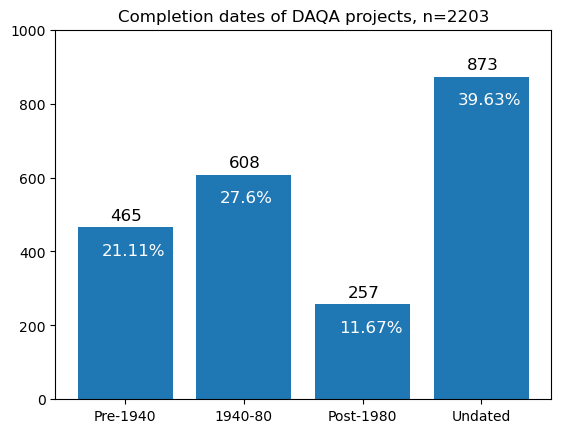

In [14]:
# store all rows with date_start in coverage_range
completion_dates_dict = {'Pre-1940': 0, '1940-80': 0, 'Post-1980': 0, 'Undated': 0}
projects_1940_80 = []
projects_1940_80_firms_dict = dict()
firms_with_projects_1940_80 = []
person_with_projects_1940_80 = []
resource_with_projects_1940_80 = []

for idx,row in daqa_work.iterrows():
    if isinstance(row['coverage_range'], str): 
        if "date_end" in row['coverage_range']:
            comp_yr = pd.json_normalize(ast.literal_eval(row['coverage_range'])['date_range'])['date_end.year'].values[0]
            # add counter for comp_yr to dict
            if int(comp_yr) < 1940: completion_dates_dict['Pre-1940'] += 1
            elif int(comp_yr) >= 1940 and int(comp_yr) <= 1980: 
                completion_dates_dict['1940-80'] += 1
                projects_1940_80.append(row['_id'])

                # add related firm to list
                if isinstance(row['related_organizations'], str):
                    related_firm = pd.json_normalize(ast.literal_eval(row['related_organizations']))['subject.ori_id'].values[0]
                    firms_with_projects_1940_80.append(related_firm)
                    projects_1940_80_firms_dict[row['_id']] = related_firm

                # add related person to list
                if isinstance(row['related_people'], str):
                    related_person = pd.json_normalize(ast.literal_eval(row['related_people']))['subject.ori_id'].values[0]
                    person_with_projects_1940_80.append(related_person)

                # add related firm to list
                if isinstance(row['related_resources'], str):
                    related_resource = pd.json_normalize(ast.literal_eval(row['related_resources']))['object.ori_id'].values[0]
                    resource_with_projects_1940_80.append(related_resource)

            elif int(comp_yr) > 1980: completion_dates_dict['Post-1980'] += 1
        else:
            completion_dates_dict['Undated'] += 1

# number of projects in DAQA
print('\nThere are {} projects in DAQA.'.format(count_projects))

# number of pre-1940 projects
print('There are {} ({}%) projects with completion dates before 1940.'.\
      format(completion_dates_dict['Pre-1940'], round((completion_dates_dict['Pre-1940']/count_projects)*100,2)))

# number of 1940-1980 projects
print('There are {} ({}%) projects with completion dates between 1940 and 1980.'.\
      format(completion_dates_dict['1940-80'], round((completion_dates_dict['1940-80']/count_projects)*100,2)))

# number of post-1980 projects
print('There are {} ({}%) projects with completion dates after 1980.'.\
      format(completion_dates_dict['Post-1980'], round((completion_dates_dict['Post-1980']/count_projects)*100,2)))

# number of undated projects
print('There are {} ({}%) projects with no completion dates.'\
      .format(completion_dates_dict['Undated'], round((completion_dates_dict['Undated']/count_projects)*100,2)))

print('\n')

# plot completion_dates_dict as a bar chart
plt.bar(range(len(completion_dates_dict)), list(completion_dates_dict.values()), align='center')
plt.xticks(range(len(completion_dates_dict)), list(completion_dates_dict.keys()))
plt.title('Completion dates of DAQA projects, n=2203')

# add labels to bars with propotion in white inside top of bar
for i, v in enumerate(completion_dates_dict.values()):
    plt.text(i - 0.125, v + 20, str(v), size=12)
    plt.text(i - 0.2, v - 75, str(round((v/count_projects)*100,2)) + '%', color='white', size=12)

# make y axis start at 0
plt.ylim(0, 1000)
plt.show()

### High-level summary of DAQA entities between 1940-1980

We are particularly interested in data between 1940-1980. Similar to what we generated for the whole dataset, we output high-level statistics for data related to projects in this 1940-1980 period.

In [15]:
# architects
# filter data accordingly
daqapersons_1940_80 = daqa_persons[daqa_persons['ori_id'].astype(int).isin(person_with_projects_1940_80)].copy()
print('Total number of persons with a related project between 1940-1980:', daqapersons_1940_80.shape[0])
architect_count = daqapersons_1940_80['longterm_roles'].value_counts().reset_index()
architect_count['Proportion'] = round(architect_count['longterm_roles']/architect_count['longterm_roles'].sum(),3)
architect_count['Type'] = np.where(architect_count['index'].str.contains('non-architect'), 'non-architect', 'architect')
display(architect_count\
        .groupby('Type')\
        .sum()\
        .reset_index()\
        .rename(columns={'longterm_roles':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# firms
# filter data accordingly
daqaorgs_1940_80 = daqa_orgs[daqa_orgs['ori_id'].astype(int).isin(firms_with_projects_1940_80)].copy()
print('\nTotal number of organisations with a related project between 1940-1980:', daqaorgs_1940_80.shape[0])
firm_count = daqaorgs_1940_80['_class_ori'].value_counts().reset_index()
firm_count['Proportion'] = round(firm_count['_class_ori']/firm_count['_class_ori'].sum(),3)
display(firm_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# projects
# filter data accordingly
daqawork_1940_80 = daqa_work[daqa_work['_id'].isin(projects_1940_80)].copy()
print('\nTotal number of works between 1940-1980 i.e, projects:', daqawork_1940_80.shape[0])
project_count = daqawork_1940_80['_class_ori'].value_counts().reset_index()
project_count['Proportion'] = round(project_count['_class_ori']/project_count['_class_ori'].sum(),3)
display(project_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

# articles
# filter data accordingly
daqaresources_1940_80 = daqa_resources[daqa_resources['ori_id'].astype(int).isin(resource_with_projects_1940_80)].copy()
print('\nTotal number of resources with a related project between 1940-1980 i.e., articles, interviews:', daqaresources_1940_80.shape[0])
article_count = daqaresources_1940_80['_class_ori'].value_counts().reset_index()
article_count['Proportion'] = round(article_count['_class_ori']/article_count['_class_ori'].sum(),3)
display(article_count\
        .groupby('index')\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'Type', '_class_ori':'Frequency'})\
        .set_index('Type')
        .sort_values('Frequency', ascending=False))

Total number of persons with a related project between 1940-1980: 113


,Frequency,Proportion
Type,,
architect,112,0.991
non-architect,1,0.009



Total number of organisations with a related project between 1940-1980: 101


,Frequency,Proportion
Type,,
"""firm""",101,1.0



Total number of works between 1940-1980 i.e, projects: 608


,Frequency,Proportion
Type,,
"""structure""",608,1.0



Total number of resources with a related project between 1940-1980 i.e., articles, interviews: 471


,Frequency,Proportion
Type,,
"""Photograph""",288,0.611
"""LineDrawing""",67,0.142
"""Image""",62,0.132
"""article""",47,0.100
"""interview""",3,0.006
"""Portrait""",2,0.004
"""publication""",2,0.004


In [16]:
relations_1940_1980 = []
for this_df in [daqapersons_1940_80,daqaorgs_1940_80,daqawork_1940_80,daqaresources_1940_80]:
    for idx,row in this_df.iterrows():
        for col in relationship_cols:
            try: 
                if isinstance(row[col], str): relations_1940_1980.append(pd.json_normalize(ast.literal_eval(row[col])))
            except: continue

relations_1940_1980 = pd.concat(relations_1940_1980)
relations_1940_1980 = relations_1940_1980.drop_duplicates()

relations_1940_1980['subject.ori_id'] = relations_1940_1980['subject.ori_id'].astype(str)
relations_1940_1980['object.ori_id'] = relations_1940_1980['object.ori_id'].astype(str)

relations_1940_1980['subject._class_ori'] = np.where(relations_1940_1980['subject._class'] == 'person', 
                                       relations_1940_1980['subject.ori_id'].map(arch_nonarch_dict), 
                                       relations_1940_1980['subject._class_ori'])
relations_1940_1980['object._class_ori'] = np.where(relations_1940_1980['object._class'] == 'person', 
                                       relations_1940_1980['object.ori_id'].map(arch_nonarch_dict), 
                                       relations_1940_1980['object._class_ori'])

# relations
print('Total number of relationships for entities related to 1940-1980 works:', relations_1940_1980.shape[0])
display(relations_1940_1980.relation_class.value_counts()\
        .reset_index()\
        .rename(columns={'index':'relation_class','relation_class':'Frequency'})\
        .assign(Proportion = lambda x: round(x['Frequency']/x['Frequency'].sum(),3))\
        .set_index('relation_class')
        .sort_values('Frequency', ascending=False))

# predicate terms
print('\nTotal number of unique predicates for entities related to 1940-1980 works:', relations_1940_1980['predicate.term'].nunique())
display(relations_1940_1980['predicate.term'].value_counts()\
        .reset_index()\
        .rename(columns={'index':'predicate.term','predicate.term':'Frequency'})\
        .assign(Proportion = lambda x: round(x['Frequency']/x['Frequency'].sum(),3))\
        .set_index('predicate.term')
        .sort_values('Frequency', ascending=False))

Total number of relationships for entities related to 1940-1980 works: 8399


,Frequency,Proportion
relation_class,,
Work_RelatedResource,2017,0.240
Person_RelatedWork,1472,0.175
Person_RelatedPerson,1218,0.145
Organization_RelatedWork,1091,0.130
Person_RelatedOrganization,903,0.108
Work_RelatedPlace,580,0.069
Person_RelatedResource,293,0.035
Resource_RelatedPerson,253,0.030
Organization_RelatedOrganization,183,0.022



Total number of unique predicates for entities related to 1940-1980 works: 32


,Frequency,Proportion
predicate.term,,
WorkedOn,2303,0.274
HasMedia,2288,0.272
Employment,760,0.090
Reference,602,0.072
LocatedIn,580,0.069
RelatedTo,436,0.052
TaughtBy,245,0.029
WorkedWith,230,0.027
InfluencedBy,160,0.019


In [17]:
print('###################### PERSON RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Person_RelatedWork','Work_RelatedPerson'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Person_RelatedPerson'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Person_RelatedOrganization','Organization_RelatedPerson'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Person_RelatedResource','Resource_RelatedPerson'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Person_RelatedRecognition'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Person_RelatedPlace'], relations=relations_1940_1980)
print('\n')

print('###################### WORK RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Work_RelatedResource','Resource_RelatedWork'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Work_RelatedPlace'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Work_RelatedRecognition'], relations=relations_1940_1980)
print('\n')

print('###################### ORGANISATION RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Organization_RelatedWork','Work_RelatedOrganization'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Organization_RelatedOrganization'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Recognition_RelatedOrganization'])

print('###################### RESOURCE RELATIONSHIPS ######################')
print('\n')
fetch_relation_details(['Resource_RelatedResource'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Resource_RelatedOrganization','Organization_RelatedResource'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Resource_RelatedPlace'], relations=relations_1940_1980)
print('\n')
fetch_relation_details(['Resource_RelatedRecognition'], relations=relations_1940_1980)
print('\n')

###################### PERSON RELATIONSHIPS ######################


Total number of Person-Work relations: 1487


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,structure,WorkedOn,1352
1,architect,structure,Reference,86
2,architect,structure,InfluencedBy,16
3,structure,architect,DesignedBy,14
4,architect,structure,StudiedAt,4
5,architect,structure,Employment,3
6,architect,structure,TravelledTo,3
7,architect,structure,Attended,2
8,architect,structure,TaughtAt,2
9,non-architect,structure,Reference,2




Total number of Person-Person relations: 1218


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,architect,TaughtBy,232
1,architect,architect,WorkedWith,209
2,architect,architect,Reference,180
3,architect,architect,InfluencedBy,127
4,architect,architect,StudiedWith,100
5,architect,architect,KnewSocially,99
6,architect,architect,Employment,84
7,architect,architect,KnewProfessionally,71
8,architect,architect,KnewOf,26
9,architect,non-architect,KnewProfessionally,13




Total number of Person-Organization relations: 908


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,firm,Employment,652
1,architect,education,StudiedAt,53
2,architect,firm,Reference,49
3,architect,firm,PartnerOf,49
4,architect,education,Employment,15
5,architect,firm,InfluencedBy,11
6,architect,firm,WorkedWith,11
7,architect,firm,TaughtBy,10
8,architect,firm,Founded,7
9,architect,firm,CollaboratedWith,6




Total number of Person-Resource relations: 546


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,architect,Reference,176
1,architect,Photograph,HasMedia,107
2,interview,architect,RelatedTo,57
3,architect,interview,RelatedTo,55
4,architect,Image,HasMedia,49
5,architect,interview,IsInvolvedIn,39
6,architect,Portrait,HasMedia,23
7,interview,non-architect,RelatedTo,18
8,non-architect,interview,RelatedTo,18
9,interview,non-architect,Reference,2




Total number of Person-Recognition relations: 22


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,award,TravelledTo,10
1,architect,award,Awarded,4
2,architect,award,Reference,4
3,architect,award,Became,2
4,architect,award,Read,1
5,architect,award,WasInfluenceBy,1




Total number of Person-Place relations: 1


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,architect,place,TravelledTo,1




###################### WORK RELATIONSHIPS ######################


Total number of Work-Resource relations: 2055


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,structure,Photograph,HasMedia,1477
1,structure,LineDrawing,HasMedia,397
2,structure,Image,HasMedia,141
3,interview,structure,Reference,38
4,structure,Portrait,HasMedia,2




Total number of Work-Place relations: 580


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,structure,place,LocatedIn,580




Total number of Work-Recognition relations: 0


,subject._class_ori,object._class_ori,predicate.term,Frequency




###################### ORGANISATION RELATIONSHIPS ######################


Total number of Organization-Work relations: 1259


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,firm,structure,WorkedOn,950
1,structure,firm,RelatedTo,144
2,firm,structure,RelatedTo,141
3,structure,firm,DesignedBy,24




Total number of Organization-Organization relations: 183


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,firm,firm,PrecededBy,93
1,firm,firm,succeededby,86
2,firm,firm,CollaboratedWith,2
3,firm,firm,MergedWith,1
4,firm,firm,WorkedWith,1




Total number of Recognition-Organization relations: 1


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,award,education,StudiedAt,1


###################### RESOURCE RELATIONSHIPS ######################


Total number of Resource-Resource relations: 49


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,article,Article,HasMedia,36
1,interview,Audio,HasMedia,6
2,interview,Transcript,HasMedia,5
3,interview,Youtube,HasMedia,2




Total number of Resource-Organization relations: 86


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,firm,Reference,41
1,firm,Photograph,HasMedia,31
2,firm,Portrait,HasMedia,9
3,firm,LineDrawing,HasMedia,2
4,firm,Image,HasMedia,1
5,interview,education,Reference,1
6,interview,organisation,Reference,1




Total number of Resource-Place relations: 2


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,place,DoneIn,2




Total number of Resource-Recognition relations: 3


,subject._class_ori,object._class_ori,predicate.term,Frequency
0,interview,award,Reference,3


### 1940-1980 projects and firms

Below are some statistics about project characteristics and firms in the DAQA dataset of only projected completed between 1940 and 1980. Proportions under the `1940-1980 PROJECTS` subheading are calculated as a percentage of the total number of projects completed between 1940 and 1980 in the dataset. Proportions under the `1940-1980 FIRMS` subheading are calculated as a percentage of the total number of firms related to projects completed between 1940 and 1980 in the dataset.

- We define an extant project as one that has a populated `is_demolished` field and the value is `False`
- We define a demolished project as one that has a populated `is_demolished` field and the value is `True`

In [18]:
print('###################### 1940-1980 PROJECTS ######################')

# filter data accordingly
daqawork_1940_80 = daqa_work[daqa_work['_id'].isin(projects_1940_80)].copy()

print('\nQ: How many projects are recorded in DAQA between 1940-1980?')
count_projects = len(daqawork_1940_80)
print(f'A: There are {count_projects} projects between 1940-1980.')

# we define a extant buiulding where "is_demolished" field is False
print('\nQ: what % of projects completed in 1940-1980 are extant?')
count_projects_extant = len(daqawork_1940_80[daqawork_1940_80['is_demolished'] == False])
prop_projects_extant = round((count_projects_extant / count_projects) * 100, 2)
print(f'A: {prop_projects_extant}% ({count_projects_extant}) of DAQA projects between 1940-1980 are extant.')

# we define a extant buiulding where "is_demolished" field is True
print('\nQ: what % of projects completed in 1940-1980 are demolished?')
count_projects_demolished = len(daqawork_1940_80[daqawork_1940_80['is_demolished'] == True])
prop_projects_demolished = round((count_projects_demolished / count_projects) * 100, 2)
print(f'A: {prop_projects_demolished}% ({count_projects_demolished}) of DAQA projects between 1940-1980 are demolished.')

print('\n*It should be noted that there are 5 DAQA projects between 1940-1980 with missing demolished information.')

# we define a project with an address as one that has a populated "address" field
print('\nQ: what % of projects between 1940-1980 have addresses?')
count_projects_with_address = len(daqawork_1940_80[daqawork_1940_80.coverage_range.apply(lambda x: "address" in x)])
prop_projects_with_address = round((count_projects_with_address / count_projects) * 100, 2)
print(f'A: {prop_projects_with_address}% ({count_projects_with_address}) of DAQA projects between 1940-1980 have addresses.')

# we define a project with a geocode date as one that has a populated "longitude" field
print('\nQ: what % of projects between 1940-1980 have geocodes (lat/long)?')
count_projects_with_geocodes = len(daqawork_1940_80[daqawork_1940_80.coverage_range.apply(lambda x: "latitude" in x)])
prop_projects_with_geocodes = round((count_projects_with_geocodes / count_projects) * 100, 2)
print(f'A: {prop_projects_with_geocodes}% ({count_projects_with_geocodes}) of DAQA projects between 1940-1980 have geocodes.')

# we define a project with an associated firm as one that has a populated "related_organizations" field
print('\nQ: how many projects between 1940-1980 have associated firms?')
daqawork_1940_80_firms = daqawork_1940_80[daqawork_1940_80.related_organizations.notnull()]
count_projects_with_firms = len(daqawork_1940_80_firms)
prop_projects_with_firms = round((count_projects_with_firms / count_projects) * 100, 2)
print(f'A: {prop_projects_with_firms}% ({count_projects_with_firms}) of DAQA projects between 1940-1980 have associated firms.')

# we define a project with no associated architects as one that has no populated "related_people" field
print('\nQ: what % of projects between 1940-1980 have associated firms but no architects?')
count_projects_with_firms_no_architects = len(daqawork_1940_80[(daqawork_1940_80.related_organizations.notnull()) &\
                                                        (daqawork_1940_80.related_people.isnull())])
prop_projects_with_firms_no_architects = round((count_projects_with_firms_no_architects / count_projects) * 100, 2)
print(f'A: {prop_projects_with_firms_no_architects}% ({count_projects_with_firms_no_architects}) of DAQA projects between 1940-1980 have associated firms but no architects.')

# we define a project with an associated architect as one that has a populated "related_people" field
print('\nQ: how many projects between 1940-1980 have associated architects?')
count_projects_with_architects = len(daqawork_1940_80[daqawork_1940_80.related_people.notnull()])
prop_projects_with_architects = round((count_projects_with_architects / count_projects) * 100, 2)
print(f'A: {prop_projects_with_architects}% ({count_projects_with_architects}) of DAQA projects between 1940-1980 have associated architects.')

# we define a project with an associated architects as one that has a populated "related people" field
# and we define a project with no associated firms as one that has a no populated "related organizations" field
print('\nQ: what % of projects between 1940-1980 have associated architects but no firms?')
count_projects_with_architects_no_firms = len(daqawork_1940_80[(daqawork_1940_80.related_organizations.isnull()) &\
                                                        (daqawork_1940_80.related_people.notnull())])
prop_projects_with_architects_no_firms = round((count_projects_with_architects_no_firms / count_projects) * 100, 2)
print(f'A: {prop_projects_with_architects_no_firms}% ({count_projects_with_architects_no_firms}) of DAQA projects between 1940-1980 have associated architects but no firms.')


print('\n###################### 1940-1980 FIRMS ######################')

# filter data accordingly
daqafirms_1940_80 = daqa_firms[daqa_firms['ori_id'].astype(int).isin(firms_with_projects_1940_80)].copy()

print('\nQ: How many firms are recorded in DAQA between 1940-1980?')
count_firms = len(daqafirms_1940_80)
print(f'A: There are {count_firms} firms between 1940-1980.')

# we define an operating firm as an organisation that has a populated "operation" field with a start date
print('\nQ: what % of firms between 1940-1980 have ‘operating years’ recorded (just start)?')
count_firms_with_operating_start = len(daqafirms_1940_80[daqafirms_1940_80.operation.apply(lambda x: "date_start" in x if isinstance(x, str) else False)])
prop_firms_with_operating_start = round((count_firms_with_operating_start / count_firms) * 100, 2)
print(f'A: {prop_firms_with_operating_start}% ({count_firms_with_operating_start}) of DAQA firms between 1940-1980 have operating years recorded (just start).')

# we define an operating firm as an organisation that has a populated "operation" field with start and end dates
print('\nQ: what % of firms between 1940-1980 have ‘operating years’ recorded (start and end)?')
count_firms_with_operating_years = len(daqafirms_1940_80[daqafirms_1940_80.operation.apply(lambda x: ("date_start" in x) & ("date_end" in x) if isinstance(x, str) else False)])
prop_firms_with_operating_years = round((count_firms_with_operating_years / count_firms) * 100, 2)
print(f'A: {prop_firms_with_operating_years}% ({count_firms_with_operating_years}) of DAQA firms between 1940-1980 have operating years recorded (start and end).')

###################### 1940-1980 PROJECTS ######################

Q: How many projects are recorded in DAQA between 1940-1980?
A: There are 608 projects between 1940-1980.

Q: what % of projects completed in 1940-1980 are extant?
A: 86.84% (528) of DAQA projects between 1940-1980 are extant.

Q: what % of projects completed in 1940-1980 are demolished?
A: 12.34% (75) of DAQA projects between 1940-1980 are demolished.

*It should be noted that there are 5 DAQA projects between 1940-1980 with missing demolished information.

Q: what % of projects between 1940-1980 have addresses?
A: 96.05% (584) of DAQA projects between 1940-1980 have addresses.

Q: what % of projects between 1940-1980 have geocodes (lat/long)?
A: 85.86% (522) of DAQA projects between 1940-1980 have geocodes.

Q: how many projects between 1940-1980 have associated firms?
A: 78.29% (476) of DAQA projects between 1940-1980 have associated firms.

Q: what % of projects between 1940-1980 have associated firms but no architec

## Education

Below are some education qualification characteristics of people records in the DAQA dataset. Proportions are calculated as a percentage of the total number of people in the dataset. 

We focus on the data of four universities: `UQ`, `BCTC`, `QIT`, and `QUT`. The latter three also grouped together, and represented as `BCTC/QIT/QUT`. We compute statistics for each university separately and then visualise the data for `UQ` and `BCTC/QIT/QUT`.

- We define a person with a education data as one that has a populated `education_trainings` field
- We define a person with a education year data as one that has a populated `date_end` field in the `education_trainings` field

In [19]:
# load data
daqa_persons = df_daqa_dict['person']
daqa_persons_with_education_data = daqa_persons[daqa_persons['education_trainings'].notnull()].copy()

print('\nQ: How many persons are recorded in DAQA?')
count_persons = len(daqa_persons)
print(f'A: There are {count_persons} people in DAQA.')

# we define a person with a education data as one that has a populated "education_trainings" field
print('\nQ: what % of people have education data?')
count_persons_with_education_data = len(daqa_persons_with_education_data)
prop_persons_with_education_data = round((count_persons_with_education_data / count_persons) * 100, 2)
print(f'A: {prop_persons_with_education_data}% ({count_persons_with_education_data}) of people with education data.')

# we define a person with a education year data as one that has a populated "date_end" field in the "education_trainings" field
print('\nQ: what % of people have education data (with years)?')
daqa_persons_with_education_year_data = daqa_persons_with_education_data[daqa_persons_with_education_data\
                                                                         .education_trainings.apply(lambda x: "date_end" in x)]
count_persons_with_education_year_data = len(daqa_persons_with_education_year_data)
prop_persons_with_education_year_data = round((count_persons_with_education_year_data / count_persons) * 100, 2)
print(f'A: {prop_persons_with_education_year_data}% ({count_persons_with_education_year_data}) of people with education year data.')


Q: How many persons are recorded in DAQA?
A: There are 1103 people in DAQA.

Q: what % of people have education data?
A: 20.58% (227) of people with education data.

Q: what % of people have education data (with years)?
A: 17.86% (197) of people with education year data.


### Queensland universities

#### UQ

In [20]:
education_training_df = pd.DataFrame()

for idx, row in daqa_persons_with_education_data.iterrows():
    person_id = row['ori_id']
    education_training_data = pd.json_normalize(ast.literal_eval(row['education_trainings']))
    education_training_data['ori_id'] = person_id
    education_training_df = education_training_df.append(education_training_data)

# remove erroneous row
education_training_df = education_training_df[~education_training_df['organization.name'].str.contains('note: interview UQ',na=False)]

def print_filtered_data(df, filter, display_output=True):
    filtered_df = df[df['organization.name'].str.contains('|'.join(filter),na=False)]
    if display_output:
        display(filtered_df['organization.name']\
                .value_counts()\
                .reset_index()\
                .rename(columns={'index': 'organization',
                                'organization.name': 'count'}))
    return filtered_df.shape[0]

print('\nQ: How many education records from UQ exist in DAQA?')
filterd_count_uq = print_filtered_data(education_training_df, ['UQ'])
print('A: There are {} education records with from UQ.'.format(filterd_count_uq))


Q: How many education records from UQ exist in DAQA?


,organization,count
0,UQ,99
1,BCTC/UQ,11
2,"QUT, UQ",1
3,BCTC?UQ,1


A: There are 112 education records with from UQ.


#### BCTC

In [21]:
print('Q: How many people have education data from BCTC?')
filterd_count_bctc = print_filtered_data(education_training_df, ['BCTC','BRISBANE'])
print('A: There are {} people with education data from BCTC.'.format(filterd_count_bctc))

Q: How many people have education data from BCTC?


,organization,count
0,BCTC,42
1,BCTC/UQ,11
2,BRISBANE CENTRAL TECHNICAL COLLEGE,3
3,BCTC?UQ,1


A: There are 57 people with education data from BCTC.


#### QIT

In [22]:
print('Q: How many people have education data from QIT?')
filterd_count_qit = print_filtered_data(education_training_df, ['QIT'])
print('A: There are {} people with education data from QIT.'.format(filterd_count_qit))

Q: How many people have education data from QIT?


,organization,count
0,QIT,21


A: There are 21 people with education data from QIT.


#### QUT

In [23]:
print('Q: How many people have education data from QUT?')
filterd_count_qut = print_filtered_data(education_training_df, ['QUT'])
print('A: There are {} people with education data from QUT.'.format(filterd_count_qut))

Q: How many people have education data from QUT?


,organization,count
0,QUT,10
1,OHIO_STATE_UNIandQUT,1
2,"QUT, UQ",1


A: There are 12 people with education data from QUT.


#### Visual comparison

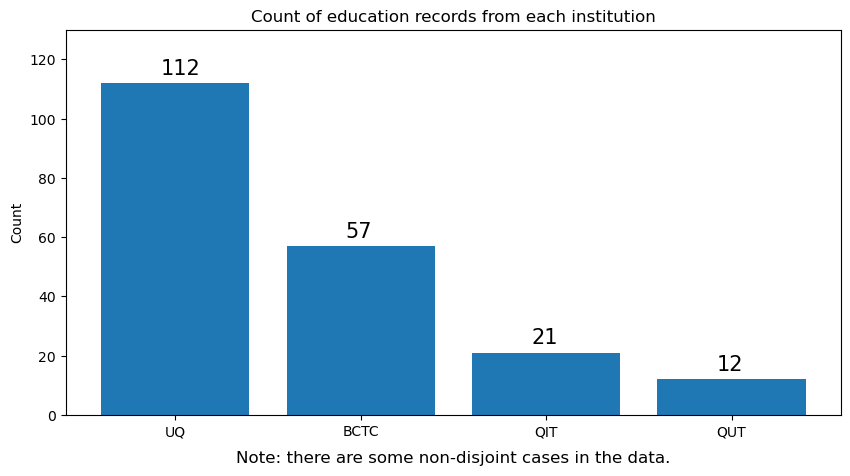

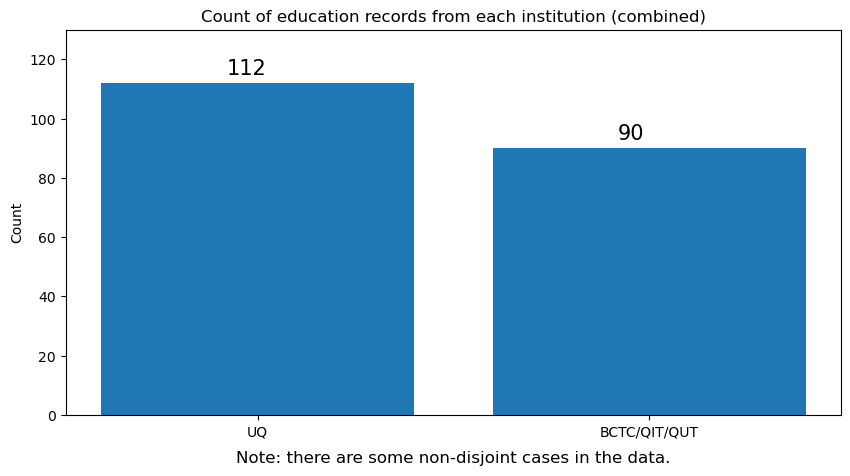

In [24]:
# create a bar chart with all the filterd_count values
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['UQ', 'BCTC', 'QIT', 'QUT'], [filterd_count_uq, filterd_count_bctc, filterd_count_qit, filterd_count_qut])
ax.set_ylabel('Count')
ax.set_title('Count of education records from each institution')
ax.text(0.5, -0.125, 'Note: there are some non-disjoint cases in the data.', size=12, ha="center", transform=ax.transAxes)
for p in ax.patches: ax.annotate(str(p.get_height()), (p.get_x()+.32, p.get_height() + 3), size=15)
ax.set_ylim([0, 130])
plt.show()

# create a bar chart with all the filterd_count values
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['UQ', 'BCTC/QIT/QUT'], [filterd_count_uq, filterd_count_bctc + filterd_count_qit + filterd_count_qut])
ax.set_ylabel('Count')
ax.set_title('Count of education records from each institution (combined)')
ax.text(0.5, -0.125, 'Note: there are some non-disjoint cases in the data.', size=12, ha="center", transform=ax.transAxes)
for p in ax.patches: ax.annotate(str(p.get_height()), (p.get_x()+.32, p.get_height() + 3), size=15)
ax.set_ylim([0, 130])
plt.show()

### Education by period

Below are some temporal statistics of education qualification data of people records in the DAQA dataset - but before computing summary statistics the data requires some cleaning. Under the heading `DATA QUALITY OF EDUCATION RECORDS`, we walk through the applied cleaning steps.

Summary statistics are presented for two periods: before 1940 and between 1940-1980. These outputs can be found under their respective subheadings. Proportions under the `1940-1980 EDUCATION` subheading are calculated as a percentage of the total number of people with education records in the dataset during this period. Proportions under the `1940-Present EDUCATION` subheading are calculated as a percentage of the total number of people with education records in the dataset during this period. 

In [25]:
print('\n###################### DATA QUALITY OF EDUCATION RECORDS ######################')

education_training_df_with_dates = education_training_df[education_training_df['coverage_range.date_range.date_end.year'].notnull()].copy()

clean_columns_dict = {'organization.name': 'name',
                      'organization.type': 'type',
                      'organization.qualification': 'qual',
                      'coverage_range.place': 'place',
                      'coverage_range.date_range.date_end.year': 'end_year',
                      'ori_id': 'ori_id'}

print('\nFor some records, the data is messy in terms of the end year for a corresponding education record.')
print('\nBelow we provide all the eductional records with unconventional values in the end year field')

check_string_len_cond = (education_training_df_with_dates['coverage_range.date_range.date_end.year'].str.len() > 4)
display(education_training_df_with_dates[check_string_len_cond]\
        .sort_values(by=['organization.name'], ascending=False)\
        .rename(columns=clean_columns_dict))

print('\n1. Remove incomplete records. These records do not hold any temporal information.')
disregard_incomplete_records = (education_training_df_with_dates['coverage_range.date_range.date_end.year'].str.contains('incom', na=False))

display(education_training_df_with_dates[check_string_len_cond & ~disregard_incomplete_records]\
        .sort_values(by=['organization.name'], ascending=False)\
        .rename(columns=clean_columns_dict))

print('\n2. Remove non-numeric suffixal characters such as "?" and "s". As we are interested in a certain period, granularity is not important.')

# remove non-numeric characters such as "?" and "s" for the end year field
education_training_df_with_dates['coverage_range.date_range.date_end.year'] = education_training_df_with_dates['coverage_range.date_range.date_end.year']\
    .str.replace('?', '', regex=False).str.replace('s', '', regex=False)

display(education_training_df_with_dates[check_string_len_cond & ~disregard_incomplete_records]\
        .sort_values(by=['organization.name'], ascending=False)\
        .rename(columns=clean_columns_dict))

print('\n3. Fix the row with two years separated by a comma. Again as we are interested in a certain period, we can temporarily replace this with the most recent year.')

# remove non-numeric characters such as "?" and "s" for the end year field
education_training_df_with_dates['coverage_range.date_range.date_end.year'] = education_training_df_with_dates['coverage_range.date_range.date_end.year']\
    .str.replace('2003, 2008', '2008', regex=False)

display(education_training_df_with_dates[check_string_len_cond & ~disregard_incomplete_records]\
        .sort_values(by=['organization.name'], ascending=False)\
        .rename(columns=clean_columns_dict))


###################### DATA QUALITY OF EDUCATION RECORDS ######################

For some records, the data is messy in terms of the end year for a corresponding education record.

Below we provide all the eductional records with unconventional values in the end year field


,name,type,qual,place,end_year,ori_id
0,UQ,UNI,NaN,QLD,incomplete,254
0,UQ,UNI,BArch,Qld,incomplete,267
1,UQ,UNI,DipArch,QLD,incomplete,384
0,UQ,UNI,DipArch,QLD,1945?,376
0,UQ,UNI,NaN,QLD,incomplete,736
1,UQ,UNI,BArch,QLD,1969?,117
3,UNSW,UNI,Archives,NSW,incomplete,384
0,STC,NSW,NaN,Colle,incom,538
2,"QUT, UQ",UNI,PhD (hon),QLD,"2003, 2008",174
0,QIT,INSTITUTE,CERT,QLD,1968?,13



1. Remove incomplete records. These records do not hold any temporal information.


,name,type,qual,place,end_year,ori_id
0,UQ,UNI,DipArch,QLD,1945?,376
1,UQ,UNI,BArch,QLD,1969?,117
2,"QUT, UQ",UNI,PhD (hon),QLD,"2003, 2008",174
0,QIT,INSTITUTE,CERT,QLD,1968?,13
0,QIT,INSTITUTE,CERT,QLD,1968?,14
0,QIT,INSTITUTE,CERT,QLD,1968?,10
0,QIT,COLLEGE,DipArch,QLD,1979?,380
0,NANGLE IoT,DISTANCE EDUCATION,DipArch,SYDNEY,1960s,355
0,Melbourne,UNI,BArch,VIC,1939?,349
1,Durhan,UNI,Landscape,UK,1965?,713



2. Remove non-numeric suffixal characters such as "?" and "s". As we are interested in a certain period, granularity is not important.


,name,type,qual,place,end_year,ori_id
0,UQ,UNI,DipArch,QLD,1945,376
1,UQ,UNI,BArch,QLD,1969,117
2,"QUT, UQ",UNI,PhD (hon),QLD,"2003, 2008",174
0,QIT,INSTITUTE,CERT,QLD,1968,13
0,QIT,INSTITUTE,CERT,QLD,1968,14
0,QIT,INSTITUTE,CERT,QLD,1968,10
0,QIT,COLLEGE,DipArch,QLD,1979,380
0,NANGLE IoT,DISTANCE EDUCATION,DipArch,SYDNEY,1960,355
0,Melbourne,UNI,BArch,VIC,1939,349
1,Durhan,UNI,Landscape,UK,1965,713



3. Fix the row with two years separated by a comma. Again as we are interested in a certain period, we can temporarily replace this with the most recent year.


,name,type,qual,place,end_year,ori_id
0,UQ,UNI,DipArch,QLD,1945,376
1,UQ,UNI,BArch,QLD,1969,117
2,"QUT, UQ",UNI,PhD (hon),QLD,2008,174
0,QIT,INSTITUTE,CERT,QLD,1968,13
0,QIT,INSTITUTE,CERT,QLD,1968,14
0,QIT,INSTITUTE,CERT,QLD,1968,10
0,QIT,COLLEGE,DipArch,QLD,1979,380
0,NANGLE IoT,DISTANCE EDUCATION,DipArch,SYDNEY,1960,355
0,Melbourne,UNI,BArch,VIC,1939,349
1,Durhan,UNI,Landscape,UK,1965,713


In [26]:
print('\n###################### 1940-1980 EDUCATION ######################')

# clean year data for temporal analysis
education_training_df_with_clean_dates = education_training_df_with_dates[~check_string_len_cond].copy()
education_training_df_with_clean_dates = education_training_df_with_clean_dates\
    .append(education_training_df_with_dates[check_string_len_cond & ~disregard_incomplete_records])

education_training_df_with_clean_dates['coverage_range.date_range.date_end.year'] = education_training_df_with_clean_dates['coverage_range.date_range.date_end.year'].astype(int)

education_training_df_1940_1980 = education_training_df_with_clean_dates[(education_training_df_with_clean_dates['coverage_range.date_range.date_end.year'] >= 1940) & \
                                                                   (education_training_df_with_clean_dates['coverage_range.date_range.date_end.year'] <= 1980)].copy()

print('\nQ: How many education records exist in DAQA between 1940-1980?')
count_ed_records_1940_1980 = len(education_training_df_1940_1980)
print(f'A: There are {count_ed_records_1940_1980} education records between 1940-1980.')

print('\nQ: How many education records exist from UQ between 1940-1980?')
count_ed_records_1940_1980_uq = print_filtered_data(education_training_df_1940_1980, ['UQ'], display_output=False)
prop_ed_records_1940_1980_uq = count_ed_records_1940_1980_uq / count_ed_records_1940_1980
print(f'A: There are {count_ed_records_1940_1980_uq} ({prop_ed_records_1940_1980_uq:.2%}) education records from UQ between 1940-1980.')

print('\nQ: How many education records exist from BCTC/QIT/QIT between 1940-1980?')
count_ed_records_1940_1980_rest = print_filtered_data(education_training_df_1940_1980, ['BCTC', 'QIT', 'QUT','BRISBANE'], display_output=False)
prop_ed_records_1940_1980_rest = count_ed_records_1940_1980_rest / count_ed_records_1940_1980
print(f'A: There are {count_ed_records_1940_1980_rest} ({prop_ed_records_1940_1980_rest:.2%}) education records from BCTC/QIT/QUT between 1940-1980.')


print('\n###################### 1940-Present EDUCATION ######################')

# remove rows with more than 4 characters in string
education_training_df_1940_present = education_training_df_with_clean_dates[(education_training_df_with_clean_dates['coverage_range.date_range.date_end.year'] >= 1940)].copy()

print('\nQ: How many education records exist in DAQA between 1940-Present?')
count_ed_records_1940_present = len(education_training_df_1940_present)
print(f'A: There are {count_ed_records_1940_present} education records between 1940-Present.')

print('\nQ: How many education records exist from UQ between 1940-Present?')
count_ed_records_1940_present_uq = print_filtered_data(education_training_df_1940_present, ['UQ'], display_output=False)
prop_ed_records_1940_present_uq = count_ed_records_1940_present_uq / count_ed_records_1940_present
print(f'A: There are {count_ed_records_1940_present_uq} ({prop_ed_records_1940_present_uq:.2%}) education records from UQ between 1940-Present.')

print('\nQ: How many education records exist from BCTC/QIT/QIT between 1940-Present?')
count_ed_records_1940_present_rest = print_filtered_data(education_training_df_1940_present, ['BCTC', 'QIT', 'QUT','BRISBANE'], display_output=False)
prop_ed_records_1940_present_rest = count_ed_records_1940_present_rest / count_ed_records_1940_present
print(f'A: There are {count_ed_records_1940_present_rest} ({prop_ed_records_1940_present_rest:.2%}) education records from BCTC/QIT/QUT between 1940-Present.')


###################### 1940-1980 EDUCATION ######################

Q: How many education records exist in DAQA between 1940-1980?
A: There are 158 education records between 1940-1980.

Q: How many education records exist from UQ between 1940-1980?
A: There are 83 (52.53%) education records from UQ between 1940-1980.

Q: How many education records exist from BCTC/QIT/QIT between 1940-1980?
A: There are 42 (26.58%) education records from BCTC/QIT/QUT between 1940-1980.

###################### 1940-Present EDUCATION ######################

Q: How many education records exist in DAQA between 1940-Present?
A: There are 193 education records between 1940-Present.

Q: How many education records exist from UQ between 1940-Present?
A: There are 98 (50.78%) education records from UQ between 1940-Present.

Q: How many education records exist from BCTC/QIT/QIT between 1940-Present?
A: There are 57 (29.53%) education records from BCTC/QIT/QUT between 1940-Present.


## Persons with related works

In this section, we explore project activity of people in DAQA. We start by first categorising people into five groups: People with one related work, 2-3 works, 4-10 works, 11-50 works, and +50 works. We then visualise the distribution of these categories. We are particulatly interested in architects with more than 50 related works. 

Given the distribution, we also explore the presence of the Pareto principle - in other words, are a majority of completed projects related to only a small number of architects? We plot the cumulative distribution of architects and their related works.

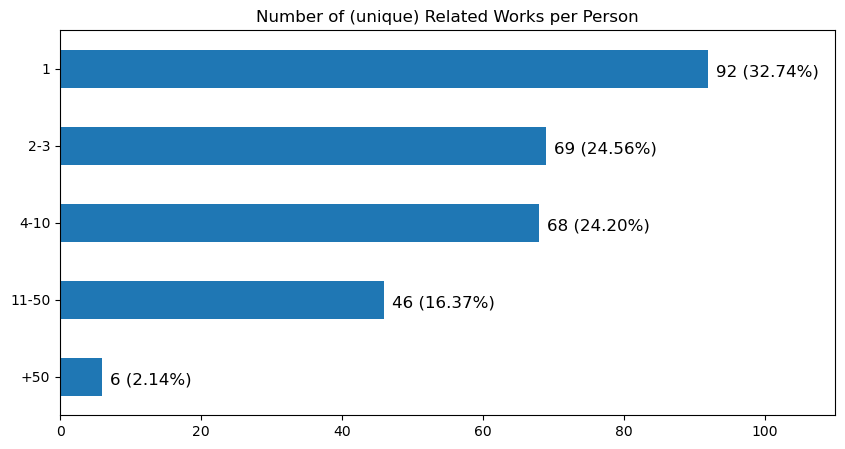


Q: Who has 50 or more related works?


,display_name,count
3,"""Lange Powell""",145
5,"""Karl Langer""",82
4,"""Graham W. Bligh""",78
0,"""Rex Addison""",75
1,"""Robin Gibson""",70
2,"""John Dalton""",67



###################### PARETO PRINCIPLE ######################


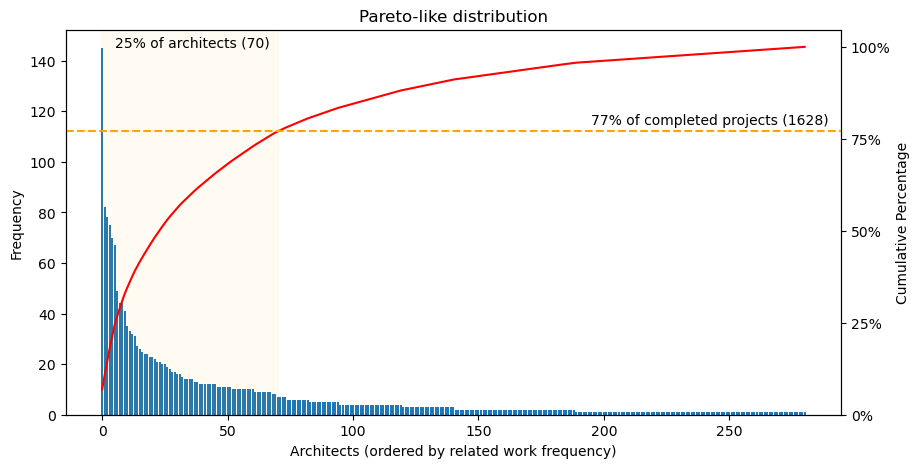

In [27]:
# load data
daqa_persons_with_related_works = daqa_persons[daqa_persons['related_works'].notnull()].copy()

related_works_raw = pd.DataFrame()
for index, row in daqa_persons_with_related_works.iterrows():
    related_works_raw = related_works_raw.append(pd.json_normalize(ast.literal_eval(row['related_works'])))

# get all person ids with related works
related_works_raw = related_works_raw[['relation_class','subject.ori_id','object.ori_id']].drop_duplicates()

Person_RelatedWork_cond = (related_works_raw['relation_class']=='Person_RelatedWork')
Work_RelatedPerson_cond = (related_works_raw['relation_class']=='Work_RelatedPerson')

person_ids_related_works = related_works_raw[Person_RelatedWork_cond]['subject.ori_id']\
    .value_counts().reset_index().rename(columns={'index': 'id', 'subject.ori_id': 'count'})\
    .append(related_works_raw[Work_RelatedPerson_cond]['object.ori_id']\
            .value_counts().reset_index().rename(columns={'index': 'id', 'object.ori_id': 'count'}))

person_ids_related_works = person_ids_related_works.groupby('id').sum().reset_index()

person_ids_related_works['count_cat'] = np.where((person_ids_related_works['count'] < 2), person_ids_related_works['count'],
                                np.where((person_ids_related_works['count'] <= 3),'2-3',
                                np.where((person_ids_related_works['count'] <= 10),'4-10',
                                np.where((person_ids_related_works['count'] <= 50),'11-50','+50'))))


# plot horizontal bar chart
ax = person_ids_related_works['count_cat'].value_counts().reindex(['1','2-3','4-10','11-50','+50']).sort_values()\
    .plot(kind='barh', figsize=(10,5), title='Number of (unique) Related Works per Person')

# add bar labels with proportions
for p in ax.patches:
    ax.annotate(f'{p.get_width()} ({p.get_width()/len(person_ids_related_works):.2%})', (p.get_width()+1.05, p.get_y()+0.15), size=12)

# increase x-axis
ax.set_xlim(0, 110)

plt.show()

print('\nQ: Who has 50 or more related works?')
person_ids_with_over50works = person_ids_related_works[person_ids_related_works['count_cat']=='+50']['id'].values.tolist()
daqa_persons['ori_id'] = daqa_persons['ori_id'].astype(int)

top_six = pd.merge(daqa_persons[daqa_persons['ori_id'].astype(int).isin(person_ids_with_over50works)][['ori_id','display_name']].rename(columns={'ori_id': 'id'}),
         person_ids_related_works[person_ids_related_works['id'].isin(person_ids_with_over50works)], on='id')

# get person records with 50 or more related works
display(top_six[['display_name','count']].sort_values(by='count', ascending=False))

print('\n###################### PARETO PRINCIPLE ######################')

#check for pareto principle
samples = pd.DataFrame({"Number of projects": person_ids_related_works['count'].sort_values(ascending=False).values})

# Add cumulative percentage column
samples["cum_percentage"] = round(samples["Number of projects"].cumsum()/samples["Number of projects"].sum()*100,2)

# Set figure and axis
fig, ax = plt.subplots(figsize=(10,5))

# Plot bars (i.e. frequencies)
ax.bar(samples.index, samples["Number of projects"])
ax.set_title('Pareto-like distribution')
ax.set_xlabel("Architects (ordered by related work frequency)")
ax.set_ylabel("Frequency")

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(samples.index, samples["cum_percentage"], color="red")
ax2.axhline(77, color="orange", linestyle="dashed", alpha=1)
ax2.yaxis.set_major_formatter(PercentFormatter())

# add more ticks to y axis
ax2.set_yticks([0,25,50,75,100])
ax2.set_ylabel("Cumulative Percentage")

# color regions on the x-axis
ax.axvspan(0, 70, alpha=0.05, color='orange')

# add an annotation for the 80% line
ax2.annotate('25% of architects (70)', xy=(0, 100), xytext=(5, 100))
ax2.annotate('77% of completed projects (1628)', xy=(0, 100), xytext=(195, 79))

plt.show()

```{epigraph}
25% of architects are related to 77% of the completed projects.
```

### Persons with related works (1940-1980)

We now explore the frequency of completed projects over time specifically between 1940 and 1980. We also visualise the frequency of completed projects by architects with more than 50 related works with the rest of the architects.

Out of the top six architects, we can see that `Lange Powell` and `Rex Addison` are not very active during this period with 0 and 20 projects respectively. We provide a breakdown for these two architects to understand which period they were most active in.

In [28]:
###################### PERSONS WITH RELATED WORK (1940-1980) ######################
all_completion_dates = []
all_completion_with_name = pd.DataFrame()

for idx,row in daqawork_1940_80.iterrows():
    comp_date = int(pd.json_normalize(ast.literal_eval(row['coverage_range']))['date_range.date_end.year'].values[0])
    all_completion_dates.append(comp_date)

    try: this_work = pd.json_normalize(ast.literal_eval(row['related_people']))[['subject.label','object.ori_id']].drop_duplicates()
    except: this_work = pd.DataFrame({'subject.label': None, 'object.ori_id': row['ori_id']}, index=[0])

    this_work['comp_date'] = comp_date
    all_completion_with_name = all_completion_with_name.append(this_work)


total_completions = pd.DataFrame(all_completion_dates)[0]\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date',0:'Frequency'}, axis=1)\
.sort_values('Completion Date')

# make interactive line plot, set figure size to 1000x500
fig = px.line(total_completions, x='Completion Date', y='Frequency', title='Total number of completed works by year, 1940-1980', 
width=900, height=500, color_discrete_sequence=['steelblue'])

fig.update_yaxes(range=[0, 55])
fig.update_yaxes(title=None)
fig.show()

print('\n###################### 1940-1980 - TOP 6 vs REST ######################')
top_six_ls = top_six['display_name'].apply(lambda x: ast.literal_eval(x)).to_list()

rest_completions = all_completion_with_name[~all_completion_with_name['subject.label'].isin(top_six_ls)]['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
rest_completions[''] = 'Rest'

lp_completions = all_completion_with_name[all_completion_with_name['subject.label']=='Lange Powell']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
lp_completions[''] = 'Lange Powell'

rg_completions = all_completion_with_name[all_completion_with_name['subject.label']=='Robin Gibson']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
rg_completions[''] = 'Robin Gibson'

jd_completions = all_completion_with_name[all_completion_with_name['subject.label']=='John Dalton']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
jd_completions[''] = 'John Dalton'

gb_completions = all_completion_with_name[all_completion_with_name['subject.label']=='Graham W. Bligh']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
gb_completions[''] = 'Graham Bligh'

kl_completions = all_completion_with_name[all_completion_with_name['subject.label']=='Karl Langer']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
kl_completions[''] = 'Karl Langer'

ra_completions = all_completion_with_name[all_completion_with_name['subject.label']=='Rex Addison']['comp_date']\
.value_counts()\
.reset_index()\
.rename({'index':'Completion Date','comp_date':'Frequency'}, axis=1)\
.sort_values('Completion Date')
ra_completions[''] = 'Rex Addison'

allcompletions = rest_completions.append(lp_completions)
allcompletions = allcompletions.append(rg_completions)
allcompletions = allcompletions.append(jd_completions)
allcompletions = allcompletions.append(gb_completions)
allcompletions = allcompletions.append(kl_completions)
allcompletions = allcompletions.append(ra_completions)

# get a table of the sum of the frequency column for each architect
allcompletions.rename({'':'Architect'}, axis=1, inplace=True)
display(allcompletions\
    .groupby('Architect')['Frequency']\
    .sum()\
    .sort_values(ascending=False)\
    .reset_index()\
    .append({'Architect':'Lange Powell', 'Frequency':0}, ignore_index=True)\
    .set_index('Architect')\
    .T)

# plot interactive time series for each architect
fig = px.line(allcompletions, x='Completion Date', y='Frequency', 
title='Total number of (completed) works by year, most active architects vs. rest, 1940-1980\n\n',
width=900, height=500, color='Architect')

# move legend to top
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.9,
    title=None
))

fig.update_yaxes(range=[0, 40])
fig.update_yaxes(title=None)
fig.show()



###################### 1940-1980 - TOP 6 vs REST ######################


Architect,Rest,John Dalton,Robin Gibson,Graham Bligh,Karl Langer,Rex Addison,Lange Powell
Frequency,524,63,44,40,39,20,0


In [29]:
print('\n###################### WHERE IS LANGE POWELL? ######################')

langepowell_relatedworks = pd.json_normalize(eval(daqa_persons.loc[daqa_persons['display_name']\
    .str.contains('Powell', na=False)]['related_works'].values[0]))['object.ori_id'].values.tolist()

langepowell_relatedworks_years = []

for i,x in daqa_work[daqa_work['ori_id'].isin(langepowell_relatedworks)].iterrows():
    try: 
        this_yr = pd.json_normalize(ast.literal_eval(x['coverage_range']))['date_range.date_end.year'].values[0]
        langepowell_relatedworks_years.append(int(str(this_yr)[:3]+'0'))
    except: pass

pd.DataFrame(langepowell_relatedworks_years)[0]\
    .value_counts()\
    .reset_index()\
    .sort_values('index')\
    .rename({'index':'decade',0:'count'}, axis=1)\
    .set_index('decade')\
    .T


###################### WHERE IS LANGE POWELL? ######################


decade,1820,1910,1920,1930,2010,2020
count,1,29,76,32,1,1


In [30]:
print('\n###################### WHERE IS REX ADDISON? ######################')

rex_addison_relatedworks = pd.json_normalize(eval(daqa_persons.loc[daqa_persons['display_name']\
    .str.contains('Rex Addison', na=False)]['related_works'].values[0]))['object.ori_id'].values.tolist()

rex_addison_relatedworks_years = []

for i,x in daqa_work[daqa_work['ori_id'].isin(rex_addison_relatedworks)].iterrows():
    try: 
        this_yr = pd.json_normalize(ast.literal_eval(x['coverage_range']))['date_range.date_end.year'].values[0]
        rex_addison_relatedworks_years.append(int(str(this_yr)[:3]+'0'))
    except: pass

pd.DataFrame(rex_addison_relatedworks_years)[0]\
    .value_counts()\
    .reset_index()\
    .sort_values('index')\
    .rename({'index':'decade',0:'count'}, axis=1)\
    .set_index('decade')\
    .T


###################### WHERE IS REX ADDISON? ######################


decade,1960,1970,1980,1990,2000
count,4,14,25,4,2


<br>

We continue our analysis during this period by identiyfing the most active architects and most active firms. We list below the top 20 for each respective entity.

In [31]:
print('###################### ARCHITECTS WITH THE HIGHEST NUMBER OF ASSOCIATED PROJECTS (1940-1980) ######################')

# names of Architects associated with the highest number of projects 1940-1980
print(f'\nThere are {all_completion_with_name["subject.label"].nunique()} unique architects with associated projects between 1940-1980.')
print('Below is a list of the top 20 architects with the highest number of associated projects within this period.')
display(all_completion_with_name['subject.label'].value_counts().head(23).reset_index().rename({'index':'Architect','subject.label':'Count'}, axis=1))

print('\n###################### FIRMS WITH THE HIGHEST NUMBER OF ASSOCIATED PROJECTS (1940-1980) ######################')
# dataframe of value counts of items in firms_with_projects_1940_80 list
firms_with_projects_1940_80_count = pd.DataFrame(firms_with_projects_1940_80, columns=['firm'])['firm']\
    .value_counts()\
    .reset_index()\
    .rename({'index':'ori_id','firm':'count'}, axis=1)

# names of firms associated with the highest number of projects 1940-1980
print(f'\nThere {firms_with_projects_1940_80_count["ori_id"].nunique()} unique firms with associated projects between 1940-1980.')
print('Below is a list of the top 20 firms with the highest number of associated projects within this period.')

display(pd.merge(daqa_orgs[['ori_id', 'primary_name']], firms_with_projects_1940_80_count, on='ori_id')\
    .sort_values('count', ascending=False)\
    .rename({'primary_name':'Firm', 'count':'Count'}, axis=1)\
    .head(20)[['Firm','Count']])

###################### ARCHITECTS WITH THE HIGHEST NUMBER OF ASSOCIATED PROJECTS (1940-1980) ######################

There are 148 unique architects with associated projects between 1940-1980.
Below is a list of the top 20 architects with the highest number of associated projects within this period.


,Architect,Count
0,John Dalton,63
1,Robin Gibson,44
2,Graham W. Bligh,40
3,Karl Langer,39
4,Rex Addison,20
5,Jon Voller,19
6,James Birrell,17
7,James Gibson,14
8,Stephen Trotter,14
9,Vitaly Gzell,13



###################### FIRMS WITH THE HIGHEST NUMBER OF ASSOCIATED PROJECTS (1940-1980) ######################

There 113 unique firms with associated projects between 1940-1980.
Below is a list of the top 20 firms with the highest number of associated projects within this period.


,Firm,Count
59,"""John Dalton Architect & Associates""",55
36,"""Karl Langer Architect""",37
62,"""Bligh Jessup Bretnall & Partners""",29
31,"""Robin Gibson & Partners""",21
56,"""Aubrey H. Job & R. P. Froud (Job & Froud)""",19
86,"""R F Gibson Architect""",18
67,"""Hayes & Scott""",17
28,"""Fulton Trotter Architects""",16
48,"""THA Cross & D Bain""",14
64,"""A.H Conrad & T.B.F Gargett""",11


### Registered architects

Below we identify all registered architects in the DAQA dataset. This information is embedded within the `career` field of each person record. We visualise a comparison of registration year and degree completion year for each architect. Note that not all architects have corresponding education data.

In [33]:
registered_architects = []
registered_architects_years = []
for idx,row in daqapersons_1940_80.iterrows():
    try:
        reg_df = pd.json_normalize(ast.literal_eval(row['career'])['registrations'])
        reg_df = reg_df[reg_df['coverage.date.year'].notnull()].sort_values('coverage.date.year')
        if reg_df.shape[0] > 0:
            closest_year = reg_df['coverage.date.year'].values[0]
            registered_architects.append(row[['display_name','ori_id', 'gender']])
            registered_architects_years.append(closest_year)
    except: pass

registered_architects = pd.DataFrame(registered_architects)
registered_architects['reg_year'] = registered_architects_years
registered_architects['gender'] = registered_architects.gender.fillna('Missing')

# fetch education details for registered architects
education_registered = education_training_df_with_dates[education_training_df_with_dates.ori_id.isin(registered_architects.ori_id)]
education_registered = education_registered[education_registered['coverage_range.date_range.date_end.year'] != 'incomplete']
education_registered = education_registered.sort_values('coverage_range.date_range.date_end.year')\
    .drop_duplicates(subset=['ori_id'], keep='first')
registered_architects = pd.merge(registered_architects, education_registered[['ori_id','coverage_range.date_range.date_end.year']], on='ori_id', how='left')

# change column name
registered_architects = registered_architects.rename({'coverage_range.date_range.date_end.year':'completion_year_first_qualification'}, axis=1)

print(f'\nThere are {registered_architects.shape[0]} architects (active in 1940-1980) with registration details in their biographical summary.')
print('-',registered_architects[registered_architects.gender == '"male"'].shape[0], 'of these are male architects.')
print('-',registered_architects[registered_architects.gender == '"female"'].shape[0], 'of these are female architects.')
# print('-',registered_architects[registered_architects.gender == 'Missing'].shape[0], 'of these does not have a recorded gender.\n')
# display(registered_architects.sort_values('reg_year', ascending=True).head())


There are 86 architects (active in 1940-1980) with registration details in their biographical summary.
- 77 of these are male architects.
- 9 of these are female architects.


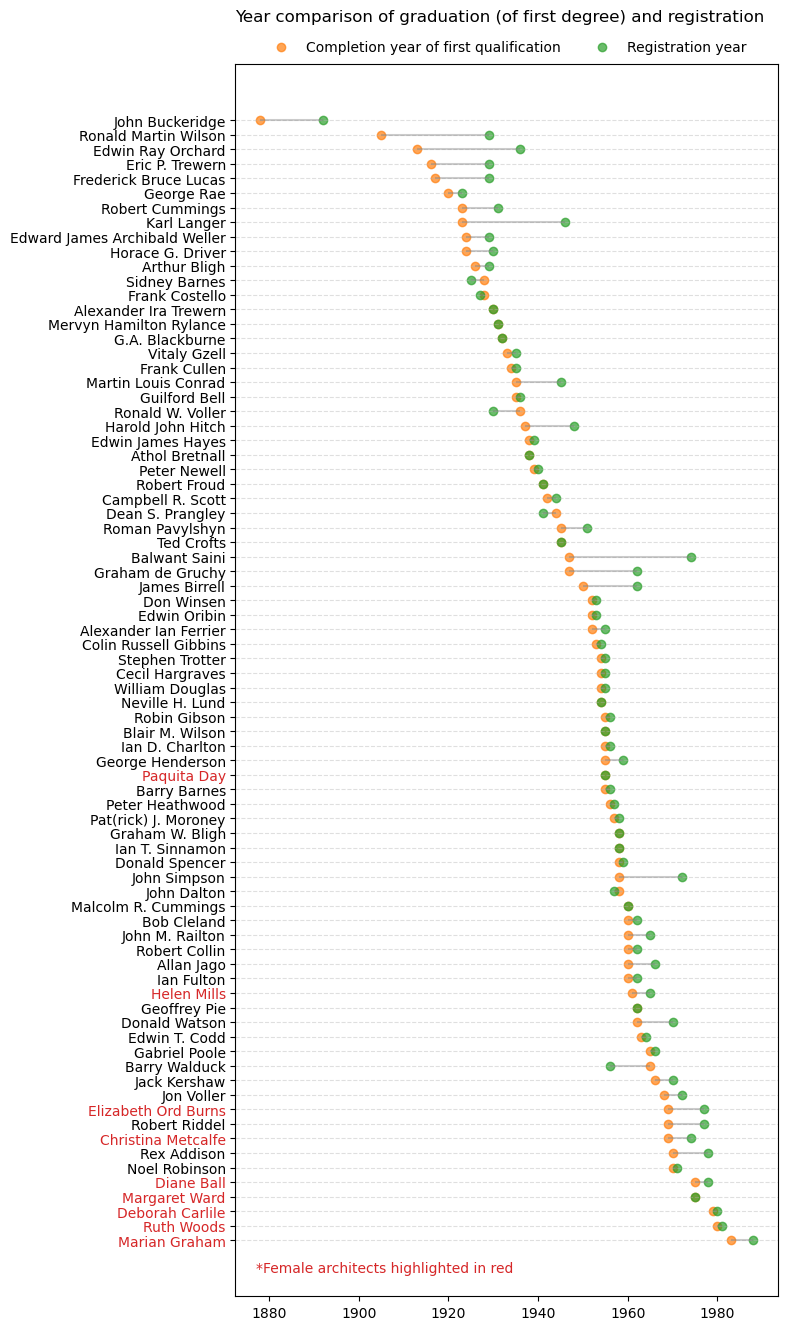

In [87]:
# plot a lollipop chart of reg_year and completion_year_first_qualification
registered_architects_with_qual = registered_architects[registered_architects['completion_year_first_qualification'].notnull()]
registered_architects_with_qual['reg_year'] = registered_architects_with_qual['reg_year'].astype(int)
registered_architects_with_qual['completion_year_first_qualification'] = registered_architects_with_qual['completion_year_first_qualification'].astype(int)
registered_architects_with_qual.sort_values('completion_year_first_qualification', ascending=False, inplace=True)
registered_architects_with_qual.reset_index(drop=True, inplace=True)
registered_architects_with_qual['display_name'] = registered_architects_with_qual['display_name'].apply(lambda x: x.replace('"',''))
registered_architects_with_qual['diff'] = registered_architects_with_qual['reg_year'] - registered_architects_with_qual['completion_year_first_qualification']

# The horizontal plot is made using the hline function
# add grid lines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.scatter(registered_architects_with_qual['completion_year_first_qualification'], 
            registered_architects_with_qual.index, color='tab:orange', alpha=0.7, label='value1')
plt.scatter(registered_architects_with_qual['reg_year'], 
            registered_architects_with_qual.index, color='tab:green', alpha=0.7 , label='value2')
 
# add legend under title and make horizontal
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, frameon=False,
           labels=['Completion year of first qualification', 'Registration year'])

# if architect is female, make line red
plt.hlines(y=registered_architects_with_qual.index, 
           xmin=registered_architects_with_qual['completion_year_first_qualification'], 
           xmax=registered_architects_with_qual['reg_year'], color='grey',
           alpha=0.4, label=False)

# Add title and axis names
plt.yticks(registered_architects_with_qual.index, registered_architects_with_qual.display_name)

# change colour of yticks based on condition
for idx,row in registered_architects_with_qual.iterrows():
    if "fe" in row['gender']: plt.gca().get_yticklabels()[idx].set_color('tab:red')

# add annoation in bottom left
plt.annotate('*Female architects highlighted in red', (0,0), (15,25), 
             xycoords='axes fraction', textcoords='offset points', va='top', color='tab:red')

plt.title("Year comparison of graduation (of first degree) and registration\n\n", loc='left')
plt.xlabel('')
plt.ylabel('')

# make plot longer 
plt.gcf().set_size_inches(7, 16)

# Show the graph
plt.show()

```{epigraph}
Based on the 78 registered architects with corresponding education data, we find that architects tend to become registered **one** year after completing their first education qualification.
```

In [146]:
# import re

# def find_word_with_regis(text):
#     # Split the text into individual words
#     words = re.findall(r'\b\w+\b', text)

#     # Search for a word that contains "regis" or "Regis"
#     for word in words:
#         if re.search(r'regis|Regis', word):
#             return word

#     return None  # No matching word found

# def find_closest_4_digit_number(string, target_word="registering"):
#     numbers = re.findall(r'\d{4}', string)  # Find all 4-digit numbers in the string
    
#     closest_number = None
#     min_distance = float('inf')
    
#     for number in numbers:
#         try:
#             distance = abs(string.index(target_word) - string.index(number))
#             if distance < min_distance:
#                 closest_number = number
#                 min_distance = distance
#         except: pass
    
#     return closest_number

# registered_architects = []
# registered_architects_years = []
# for idx,row in daqapersons_1940_80.iterrows():
#     try:
#         if ("registering" in row['summary']) | ("registered" in row['summary']) | \
#         ("Registered" in row['summary']) | ("architectural registration" in row['summary']) | ("Registration" in row['summary']):
#             registered_architects.append(row[['display_name','ori_id', 'gender']])
#             this_summary = pd.Series(row['summary'].split('. '))
#             register_pos = this_summary.apply(lambda x: x.strip()).str.contains('regis|Regis').values.tolist().index(True)
#             result = find_word_with_regis(this_summary[register_pos])
#             closest_year = find_closest_4_digit_number(this_summary[register_pos], target_word=result)
#             registered_architects_years.append(closest_year)
#     except: pass

# registered_architects = pd.DataFrame(registered_architects)
# registered_architects['reg_year'] = registered_architects_years
# registered_architects['gender'] = registered_architects.gender.fillna('Missing')

# # fetch education details for registered architects
# education_registered = education_training_df_with_dates[education_training_df_with_dates.ori_id.isin(registered_architects.ori_id)]
# education_registered = education_registered[education_registered['coverage_range.date_range.date_end.year'] != 'incomplete']
# education_registered = education_registered.sort_values('coverage_range.date_range.date_end.year')\
#     .drop_duplicates(subset=['ori_id'], keep='first')
# registered_architects = pd.merge(registered_architects, education_registered[['ori_id','coverage_range.date_range.date_end.year']], on='ori_id', how='left')

# # change column name
# registered_architects = registered_architects.rename({'coverage_range.date_range.date_end.year':'completion_year_first_qualification'}, axis=1)

# print(f'\nThere are {registered_architects.shape[0]} architects (active in 1940-1980) with registration details in their biographical summary.')
# print('-',registered_architects[registered_architects.gender == '"male"'].shape[0], 'of these are male architects.')
# print('-',registered_architects[registered_architects.gender == '"female"'].shape[0], 'of these are female architects.')
# print('-',registered_architects[registered_architects.gender == 'Missing'].shape[0], 'of these does not have a recorded gender.\n')
# display(registered_architects.sort_values('reg_year', ascending=True))

In [147]:
# # plot a lollipop chart of reg_year and completion_year_first_qualification
# registered_architects_with_qual = registered_architects[registered_architects['completion_year_first_qualification'].notnull()]
# registered_architects_with_qual['reg_year'] = registered_architects_with_qual['reg_year'].astype(int)
# registered_architects_with_qual['completion_year_first_qualification'] = registered_architects_with_qual['completion_year_first_qualification'].astype(int)
# registered_architects_with_qual.sort_values('completion_year_first_qualification', ascending=True, inplace=True)
# registered_architects_with_qual.reset_index(drop=True, inplace=True)
# registered_architects_with_qual['display_name'] = registered_architects_with_qual['display_name'].apply(lambda x: x.replace('"',''))
# registered_architects_with_qual['diff'] = registered_architects_with_qual['reg_year'] - registered_architects_with_qual['completion_year_first_qualification']

# # The horizontal plot is made using the hline function
# # add grid lines for y-axis
# plt.grid(axis='y', linestyle='--', alpha=0.4)

# plt.scatter(registered_architects_with_qual['completion_year_first_qualification'], 
#             registered_architects_with_qual.index, color='tab:orange', alpha=0.7, label='value1')
# plt.scatter(registered_architects_with_qual['reg_year'], 
#             registered_architects_with_qual.index, color='tab:green', alpha=0.7 , label='value2')
 
# # add legend under title and make horizontal
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.065), ncol=3, frameon=False,
#            labels=['Completion year of first qualification', 'Registration year'])

# plt.hlines(y=registered_architects_with_qual.index, 
#            xmin=registered_architects_with_qual['completion_year_first_qualification'], 
#            xmax=registered_architects_with_qual['reg_year'], color='grey', alpha=0.4, label=False)

# # Add title and axis names
# plt.yticks(registered_architects_with_qual.index, registered_architects_with_qual.display_name)
# plt.title("Year comparison of graduation (of first degree) and registration\n\n", loc='left')
# plt.xlabel('')
# plt.ylabel('')

# # make plot longer 
# plt.gcf().set_size_inches(7, 8)

# # Show the graph
# plt.show()

### Women with related works

We compare the frequency of completed projects by males and females between two periods 1940-1980, and 1980-Present.

In [148]:
print('\n###################### FEMAlE ARCHITECTS (1940-1980) ######################')
projects_1940_80 = []
projects_1980_present = []

for idx,row in daqa_work.iterrows():
    if isinstance(row['coverage_range'], str): 
        if "date_end" in row['coverage_range']:
            comp_yr = pd.json_normalize(ast.literal_eval(row['coverage_range'])['date_range'])['date_end.year'].values[0]
            # add counter for comp_yr to dict
            if int(comp_yr) >= 1940 and int(comp_yr) <= 1980: 
                projects_1940_80.append(row['_id']) 

            if int(comp_yr) > 1980: 
                projects_1980_present.append(row['_id'])

daqawork_1940_80 = daqa_work[daqa_work['_id'].isin(projects_1940_80)]
daqawork_1980_present = daqa_work[daqa_work['_id'].isin(projects_1980_present)]

# store all rows with date_start in coverage_range
all_completion_with_name_1940_80 = pd.DataFrame()

for idx,row in daqawork_1940_80.iterrows():
    comp_date = int(pd.json_normalize(ast.literal_eval(row['coverage_range']))['date_range.date_end.year'].values[0])

    try: this_work = pd.json_normalize(ast.literal_eval(row['related_people']))[['subject.label','object.ori_id']].drop_duplicates()
    except: this_work = pd.DataFrame({'subject.label': None, 'object.ori_id': row['ori_id']}, index=[0])

    this_work['comp_date'] = comp_date
    all_completion_with_name_1940_80 = all_completion_with_name_1940_80.append(this_work)

# store all rows with date_start in coverage_range
all_completion_with_name_1980_present = pd.DataFrame()

for idx,row in daqawork_1980_present.iterrows():
    comp_date = int(pd.json_normalize(ast.literal_eval(row['coverage_range']))['date_range.date_end.year'].values[0])

    try: this_work = pd.json_normalize(ast.literal_eval(row ['related_people']))[['subject.label','object.ori_id']].drop_duplicates()
    except: this_work = pd.DataFrame({'subject.label': None, 'object.ori_id': row['ori_id']}, index=[0])

    this_work['comp_date'] = comp_date
    all_completion_with_name_1980_present = all_completion_with_name_1980_present.append(this_work)

persons_gender = daqa_persons[['display_name','gender']].copy()
persons_gender['display_name'] = persons_gender['display_name'].apply(lambda x: ast.literal_eval(x))

persons_gender_1940_1980 = pd.merge(all_completion_with_name_1940_80, persons_gender, right_on='display_name', left_on='subject.label')
persons_gender_1940_1980['gender'].fillna('Missing', inplace=True)
persons_gender_1940_1980 = persons_gender_1940_1980['gender'].value_counts().reset_index().rename({'index':'Gender', 'gender':'Count'},axis=1)

print('\nQ: what % of projects completed in 1940-1980 were associated with a male architect?')
count_projects_all = persons_gender_1940_1980['Count'].sum()
male_count = persons_gender_1940_1980[persons_gender_1940_1980['Gender'].str.contains('''"male"''')]['Count'].values[0]
prop_projects_male = round((male_count / count_projects_all) * 100, 2)
print(f'A: {prop_projects_male}% ({male_count}) of architects associated with projects completed in 1940-1980 were male.')

print('\nQ: what % of projects completed in 1940-1980 were associated with a female architect?')
female_count = persons_gender_1940_1980[persons_gender_1940_1980['Gender'].str.contains('''"female"''')]['Count'].values[0]
prop_projects_female = round((female_count / count_projects_all) * 100, 2)
print(f'A: {prop_projects_female}% ({female_count}) of architects associated with projects completed in 1940-1980 were female.')

print('\n*It should be noted that there are 6 DAQA projects between 1940-1980 with missing gender information.')

print('\n###################### FEMAlE ARCHITECTS (1980-Present) ######################')

persons_gender_1980_present = pd.merge(all_completion_with_name_1980_present, persons_gender, right_on='display_name', left_on='subject.label')
persons_gender_1980_present['gender'].fillna('Missing', inplace=True)
persons_gender_1980_present = persons_gender_1980_present['gender'].value_counts().reset_index().rename({'index':'Gender', 'gender':'Count'},axis=1)

print('\nQ: what % of projects completed after 1980 were associated with a male architect?')
count_projects_all = persons_gender_1980_present['Count'].sum()
male_count = persons_gender_1980_present[persons_gender_1980_present['Gender'].str.contains('''"male"''')]['Count'].values[0]
prop_projects_male = round((male_count / count_projects_all) * 100, 2)
print(f'A: {prop_projects_male}% ({male_count}) of architects associated with projects completed affter 1980 were male.')

print('\nQ: what % of projects completed after 1980 were associated with a female architect?')
female_count = persons_gender_1980_present[persons_gender_1980_present['Gender'].str.contains('''"female"''')]['Count'].values[0]
prop_projects_female = round((female_count / count_projects_all) * 100, 2)
print(f'A: {prop_projects_female}% ({female_count}) of architects associated with projects completed after 1980 were female.')

print('\n*It should be noted that there are 8 DAQA projects after 1980 with missing gender information.')


###################### FEMAlE ARCHITECTS (1940-1980) ######################

Q: what % of projects completed in 1940-1980 were associated with a male architect?
A: 92.54% (571) of architects associated with projects completed in 1940-1980 were male.

Q: what % of projects completed in 1940-1980 were associated with a female architect?
A: 6.48% (40) of architects associated with projects completed in 1940-1980 were female.

*It should be noted that there are 6 DAQA projects between 1940-1980 with missing gender information.

###################### FEMAlE ARCHITECTS (1980-Present) ######################

Q: what % of projects completed after 1980 were associated with a male architect?
A: 64.34% (184) of architects associated with projects completed affter 1980 were male.

Q: what % of projects completed after 1980 were associated with a female architect?
A: 32.87% (94) of architects associated with projects completed after 1980 were female.

*It should be noted that there are 8 DAQA pro

## Typologies

Below we visualise the frequency of typologies in the DAQA dataset. We continue our analysis by focusing on the period of 1940 to 1980, as well as idenyifing the arcihtects and firms with the most related projects for each typology within this period.

In [149]:
daqa_work_years = []
daqa_work_ori_ids = []

for idx,row in daqa_work.iterrows():
    try: comp_yr = pd.json_normalize(ast.literal_eval(row['coverage_range'])['date_range'])['date_end.year'].values[0]
    except: comp_yr = None
    daqa_work_years.append(comp_yr)
    daqa_work_ori_ids.append(row['ori_id'])

# create a dummy variable for each typology
typology_dummies_daqa_work = pd.get_dummies(daqa_work['typologies'].\
    fillna('Missing')\
    .str.replace('[^a-zA-Z, ]', '', regex=True)\
    .str.split(', ')\
    .apply(pd.Series).stack())\
    .sum(level=0)

typology_dummies_daqa_work['extracted_compyear'] = daqa_work_years

# create a dataframe with value counts for each typology and year
typology_dummies_counts = typology_dummies_daqa_work.groupby('extracted_compyear')\
    .sum()\
    .reset_index()

typology_dummies_counts['extracted_compyear'] = typology_dummies_counts['extracted_compyear'].astype(int)

# remove erronoous year 1220 and 2029
typology_dummies_counts = typology_dummies_counts.iloc[1:,].head(-1)

# add row for missing years between 1820 and 2022
typology_dummies_counts = typology_dummies_counts\
    .append(pd.DataFrame({'extracted_compyear':list(range(1820,2022))}), ignore_index=True)\
    .fillna(0)\
    .drop_duplicates('extracted_compyear',keep='first')\
    .sort_values('extracted_compyear')

# plot interactve time series for each typology
fig = px.line(typology_dummies_counts, x='extracted_compyear', y=typology_dummies_counts.columns[1:],
title='Number of works by typology and year, 1820-2021',
width=1000, height=500, color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_yaxes(range=[0, 30])
fig.update_yaxes(title=None)
fig.update_xaxes(title='Year of completion')

# add subtitle
fig.add_annotation(x=0.5, y=1.07, xref='paper', yref='paper',
text='Note: there are some non-disjoint cases in the data.', showarrow=False, font=dict(size=12))

# change legend title from "variable" to "typology"
fig.update_layout(legend_title_text='Typology')

fig.show()

### Typologies (1940-1980)

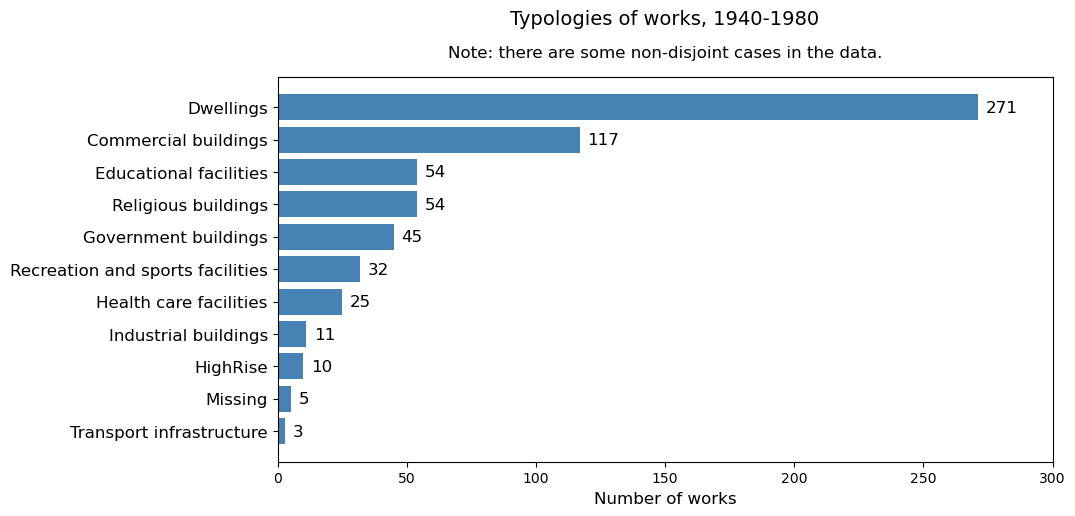

In [150]:
# create a dummy variable for each typology
typology_dummies = pd.get_dummies(daqawork_1940_80['typologies'].\
    fillna('Missing')\
    .str.replace('[^a-zA-Z, ]', '', regex=True)\
    .str.split(', ')\
    .apply(pd.Series).stack())\
    .sum(level=0)

# create a dataframe with value counts for each typology and their proportion of the total
typology_dummies_counts = typology_dummies.sum()\
    .reset_index()\
    .rename({'index':'typology',0:'count'}, axis=1)\
    .sort_values('count', ascending=False)\
    .reset_index(drop=True)

# matplotlib plot the freuqencies of typologies with bar labels and switch order of y axis
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(typology_dummies_counts['typology'], typology_dummies_counts['count'], color='steelblue')
ax.set_yticklabels(typology_dummies_counts['typology'], fontsize=12)
ax.set_xlim(0, 300)
ax.set_xlabel('Number of works', fontsize=12)
ax.set_ylabel('')
ax.set_title('Typologies of works, 1940-1980\n\n', fontsize=14)
ax.invert_yaxis()

# add bar labels with proportions in brackets
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width()+3, p.get_y()+0.55), size=12)

ax.text(0.5, 1.05, 'Note: there are some non-disjoint cases in the data.', size=12, ha="center", transform=ax.transAxes)

plt.show()

#### Top 5 architects

In [151]:
typology_dummies_daqa_work['ori_id'] = daqa_work_ori_ids
typology_architects = pd.merge(typology_dummies_daqa_work, 
                               all_completion_with_name[['subject.label','object.ori_id']], 
                               left_on='ori_id', right_on='object.ori_id').drop(['extracted_compyear','ori_id','object.ori_id'], axis=1)

# get the sum of each typology for each firm
typology_architects = typology_architects.groupby('subject.label').sum().reset_index()

for typology in typology_architects.columns[1:]:
    print(f'\n{typology}')
    
    typology_architects_top5 = typology_architects[['subject.label', typology]]\
        .sort_values(typology, ascending=False)\
        .rename({typology:f'{typology} count'}, axis=1)
    
    typology_architects_top5 = typology_architects_top5[typology_architects_top5[f'{typology} count'] > 0].head(5)

    display(typology_architects_top5\
    .sort_values(f'{typology} count', ascending=False)\
    .rename({'subject.label':'Architect'}, axis=1)[['Architect', f'{typology} count']])


Commercial buildings


,Architect,Commercial buildings count
60,Graham W. Bligh,22
125,Robin Gibson,16
92,Karl Langer,9
54,Geoffrey Pie,4
132,Stephen Trotter,4



Dwellings


,Architect,Dwellings count
82,John Dalton,62
92,Karl Langer,15
125,Robin Gibson,10
34,Donald Spencer,9
137,Vitaly Gzell,9



Educational facilities


,Architect,Educational facilities count
125,Robin Gibson,6
60,Graham W. Bligh,6
118,Rex Addison,6
132,Stephen Trotter,5
90,Jon Voller,5



Government buildings


,Architect,Government buildings count
92,Karl Langer,5
90,Jon Voller,3
125,Robin Gibson,3
60,Graham W. Bligh,3
127,Roman Pavylshyn,3



Health care facilities


,Architect,Health care facilities count
131,Sidney Barnes,5
22,Charles W. T. Fulton,2
17,Bruce Paulsen,1
46,Elmars A. Kraams,1
101,Margaret Ward,1



HighRise


,Architect,HighRise count
68,Ian D. Charlton,1
125,Robin Gibson,1
134,Ted Crofts,1
77,Jan van den Broek,1



Industrial buildings


,Architect,Industrial buildings count
125,Robin Gibson,6
131,Sidney Barnes,1
137,Vitaly Gzell,1
92,Karl Langer,1
48,Frank Costello,1



Missing


,Architect,Missing count
104,Martin Louis Conrad,1
115,Peter Newell,1
108,Neville H. Lund,1



Recreation and sports facilities


,Architect,Recreation and sports facilities count
63,Guy Crick,4
75,James Birrell,3
42,Edwin Oribin,3
118,Rex Addison,3
74,Jack McElroy,3



Religious buildings


,Architect,Religious buildings count
76,James Gibson,14
92,Karl Langer,5
42,Edwin Oribin,4
1,Alexander Ian Ferrier,3
81,John Buckeridge,3



Transport infrastructure


,Architect,Transport infrastructure count
10,Balwant Saini,1
92,Karl Langer,1
60,Graham W. Bligh,1


#### Top 5 firms

In [152]:
# convert projects_1940_80_firms_dict to dataframe
typology_dummies['_id'] = daqawork_1940_80[['_id']]
typology_firms = pd.merge(typology_dummies,
                    pd.DataFrame.from_dict(projects_1940_80_firms_dict, orient='index')\
                        .reset_index()\
                        .rename({'index':'_id', 0:'ori_id'}, axis=1))

# get the sum of each typology for each firm
typology_firms = typology_firms.groupby('ori_id').sum().reset_index()

for typology in typology_dummies_counts['typology'].values:
    print(f'\n{typology}')
    
    typology_firms_top5 = typology_firms[['ori_id', typology]]\
        .sort_values(typology, ascending=False)\
        .rename({typology:f'{typology} count'}, axis=1)
    
    typology_firms_top5 = typology_firms_top5[typology_firms_top5[f'{typology} count'] > 0].head(5)
    
    display(pd.merge(daqa_orgs[['ori_id', 'primary_name']], typology_firms_top5, on='ori_id')\
    .sort_values(f'{typology} count', ascending=False)\
    .rename({'primary_name':'Firm'}, axis=1)[['Firm', f'{typology} count']])


Dwellings


,Firm,Dwellings count
2,"""John Dalton Architect & Associates""",54
1,"""Aubrey H. Job & R. P. Froud (Job & Froud)""",18
3,"""Hayes & Scott""",16
0,"""Karl Langer Architect""",13
4,"""John Railton Architect""",7



Commercial buildings


,Firm,Commercial buildings count
2,"""Bligh Jessup Bretnall & Partners""",18
1,"""Karl Langer Architect""",8
4,"""R F Gibson Architect""",8
0,"""Robin Gibson & Partners""",5
3,"""Theo Thynne & Associates""",4



Educational facilities


,Firm,Educational facilities count
2,"""Cullen Hargraves Mooney""",6
0,"""Fulton Trotter Architects""",5
1,"""Robin Gibson & Partners""",5
4,"""Bligh Jessup Bretnall & Partners""",4
3,"""Goodsir Baker Wilde""",3



Religious buildings


,Firm,Religious buildings count
3,"""THA Cross & D Bain""",14
2,"""Karl Langer Architect""",5
4,"""S.G. Barnes & Oribin""",5
0,"""Ian A Ferrier""",3
1,"""W L Douglas & B Barnes""",3



Government buildings


,Firm,Government buildings count
1,"""Karl Langer Architect""",5
2,"""Bligh Jessup Bretnall & Partners""",3
3,"""Conrad Gargett & Partners (1965-1972)""",3
4,"""Commonwealth Department of Works""",3
0,"""Robin Gibson & Partners""",2



Recreation and sports facilities


,Firm,Recreation and sports facilities count
1,"""A.H Conrad & T.B.F Gargett""",3
4,"""Brisbane City Council, City Design""",3
0,"""Karl Langer Architect""",2
3,"""S.G. Barnes & Oribin""",2
2,"""James Birrell & Partners""",1



Health care facilities


,Firm,Health care facilities count
2,"""S.G. Barnes""",4
4,"""J M Collin & C W T Fulton""",4
1,"""A.H Conrad & T.B.F Gargett""",2
0,"""Donald W Spencer""",1
3,"""Theo Thynne & Associates""",1



Industrial buildings


,Firm,Industrial buildings count
0,"""Robin Gibson & Partners""",3
4,"""R F Gibson Architect""",3
1,"""Karl Langer Architect""",1
2,"""S.G. Barnes""",1
3,"""Theo Thynne & Associates""",1



HighRise


,Firm,HighRise count
3,"""Prangley & Crofts""",4
4,"""Theo Thynne, Denham & Associates""",2
0,"""Curro Nutter & Charlton""",1
1,"""Robin Gibson & Partners""",1
2,"""Peddle Thorp & Walker""",1



Missing


,Firm,Missing count
0,"""Martin L Conrad Architects""",1
1,"""Hennessy, Hennessy & Co""",1
2,"""Lund, Hutton & Newell""",1
3,"""Ford, Hutton & Newell""",1



Transport infrastructure


,Firm,Transport infrastructure count
0,"""Karl Langer Architect""",1
1,"""Bligh Jessup Bretnall & Partners""",1


## Interviews

Below we explore the frequency of interviews by interviewers. We focus only on intereviews with architect interviewees.

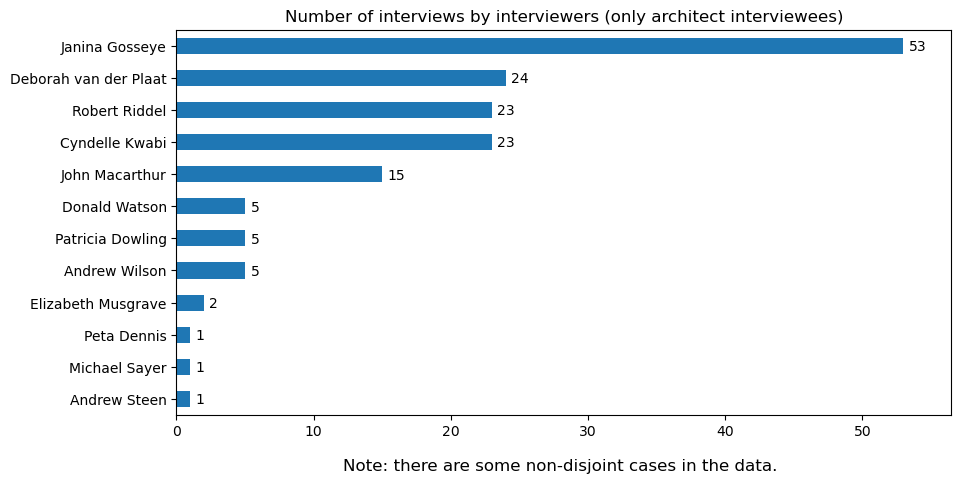

In [153]:
# load data
daqa_resources = df_daqa_dict['resource']
daqa_interviews = daqa_resources[daqa_resources['_class_ori'].str.contains('interview', na=False)]

interviewers = []
interview_data = []

for idx,row in daqa_interviews.iterrows():
    try: 
        interviewees_isarchitect = pd.json_normalize(json.loads(row['interviewee']))['architect'].values.tolist()
        if True in interviewees_isarchitect:
            interview_data.append(pd.json_normalize(json.loads(row['interviewee'])))
            interviewers.extend(pd.json_normalize(json.loads(row['interviewer']))['label'].values.tolist())
    except: pass


# plot bar plot of interviewers
interviewers = pd.Series(interviewers)
interviewers.value_counts().plot(kind='barh', figsize=(10,5), title='Number of interviews by interviewers (only architect interviewees)')

# inverse y-axis
plt.gca().invert_yaxis()

# add bar labels and propotions
for i, v in enumerate(interviewers.value_counts()):
    plt.text(v + .4, i + .15, str(v), color='black')

plt.xlim(0, 56.5)
plt.text(28, 13.25, 'Note: there are some non-disjoint cases in the data.', size=12, ha="center")
plt.show()

In [154]:
daqa_persons_interviewed = daqa_persons[daqa_persons["display_name"].apply(lambda x: x.replace('"','')).isin(pd.concat(interview_data)['label'].unique())]

interviewed_orgs = []
for idx,row in daqa_persons_interviewed.iterrows():
    try: interviewed_orgs.append(pd.json_normalize(json.loads(row['related_organizations'])))
    except: pass

interviewed_orgs = pd.concat(interviewed_orgs)
print('Count of interviewed architects by organisation, Top 8:')
interviewed_orgs = interviewed_orgs[interviewed_orgs["predicate.term"] == 'Employment'][["subject.label", "object.label"]].drop_duplicates()
display(interviewed_orgs['object.label'].value_counts().head(8))

avg_no_emnployers = interviewed_orgs.groupby('subject.label').count().reset_index().rename({'object.label':'count'}, axis=1)['count'].median()

Count of interviewed architects by organisation, Top 8:


Conrad Gargett & Partners (1965-1972)               19
Queensland Government Department of Public Works    12
Bligh Jessup Bretnall & Partners                    11
The University of Queensland                         8
Commonwealth Department of Works                     7
A.H Conrad & T.B.F Gargett                           7
Conrad Gargett & Partners (1972-1995)                6
Brisbane City Council                                5
Name: object.label, dtype: int64

```{epigraph}
On average, interviewed architects have worked for **5 employers**.
```

## Socioeconomic factors 
Below we overlay the DAQA dataset (completed projects) with socioeconomic data from the Australian Bureau of Statistics (ABS), Queensland Government Statistician's Office (QGSO) and Department of Foreign Affairs and Trade (DFAT). Factors include GDP, overseas migration, interstate migration, employment and buildings approved. Most measures are specific to Queensland.

As data is recorded in two forms, by calendar year and financial year, we have developed two applications to explore the data. Applications can be accessed using the following links:

**By calendar year**: [https://daqa-socioecon-cy-dashapp.onrender.com](https://daqa-socioecon-cy-dashapp.onrender.com)

**By financial year**: [https://daqa-socioeconomic-fy.onrender.com/](https://daqa-socioeconomic-fy.onrender.com)
</br>

The applications consist of the following demographic variables:

### ABS data

Dataset: 3105.0.65.001 Australian Historical Population Statistics, Migration, 2014

Source: [https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3105.0.65.0012014](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3105.0.65.0012014)

Sheet name: Table 7.2

- **QLD_Net overseas migration**
    </br>

    Net overseas migration (a)(b)(c), Queensland, 1972-2011, FY
    </br>

    (a)  From September quarter 1971 to June quarter 2006 inclusive, net overseas migration (NOM) was the difference between permanent and long-term arrivals and permanent and long-term departures. For September quarter 2006 onwards estimates for NOM are the difference between the number of incoming travellers who stay in Australia for 12 months or more and are added to the population (NOM arrivals) and the number of outgoing travellers who leave Australia for 12 months or more and are subtracted from the population (NOM departures). See paragraphs 51 to 54 of the Explanatory Notes.													
                                                                                            
    (b)  Estimates for net overseas migration (NOM) contain a break in time series. Estimates for September quarter 2006 onwards use an improved methodology based on the 12/16 rule and are not comparable with NOM estimates prior to this based on the 12/12 rule. See paragraph 51 of the Explanatory Notes.													
                                                        
    (c)  An adjustment for category jumping (later referred to as migration adjustments) was included for estimates for September quarter 1976 to June quarter 2006, except for September quarter 1997 to June quarter 2001 when it was set to zero. See paragraphs 55 to 57 of the Explanatory Notes.													
    </br>
    
    Sources: ABS data available on request, Population Estimates (for years 1972 - 1981); Australian Demographic Statistics (cat. no. 3101.0) (for years 1982 - 2011)

</br>

Sheet name: Table 7.3

- **QLD_InterstateMigration_Arrivals_To**
    </br>

    Interstate migration, arrivals, Queensland, 1972-2010, CY
    </br>

    Sources: ABS data available on request, Population Estimates (for years 1972 - 1981); Australian Demographic Statistics (cat. no. 3101.0) (1982 - 2010)

- **QLD_InterstateMigration_Departures_from**
    </br>

    Interstate migration, departures, Queensland, 1972-2010, CY
    </br>

    Sources: ABS data available on request, Population Estimates (for years 1972 - 1981); Australian Demographic Statistics (cat. no. 3101.0) (1982 - 2010)

- **QLD_Net interstate migration**
    </br>

    Net interstate migration, arrivals, Queensland, 1972-2010, CY
    </br>

    Sources: ABS data available on request, Population Estimates (for years 1972 - 1981); Australian Demographic Statistics (cat. no. 3101.0) (1982 - 2010)

</br>

Sheet name: Table 7.5

- **QLD_Net interstate and overseas migration**
    </br>

    Net interstate and overseas migration(a)(b)(c), Queensland, 1860-2010, CY
    </br>

    (a)  Until June quarter 1971, net overseas migration (NOM) was the difference between total arrivals and total departures, including short-term movements. From September quarter 1971 to June quarter 2006 inclusive, NOM was the difference between permanent and long-term arrivals and permanent and long-term departures. For September quarter 2006 onwards estimates for NOM are the difference between the number of incoming travellers who stay in Australia for 12 months or more and are added to the population (NOM arrivals) and the number of outgoing travellers who leave Australia for 12 months or more and are subtracted from the population (NOM departures). See paragraphs 51 to 54 of the Explanatory Notes.														
                                                                                      
    (b)  Estimates for net overseas migration (NOM) contain a break in time series. Estimates for September quarter 2006 onwards use an improved methodology based on the 12/16 rule and are not comparable with NOM estimates prior to this based on the 12/12 rule. See paragraph 51 of the Explanatory Notes.														
                                                            
    (c)  An adjustment for category jumping (later referred to as migration adjustments) was included for estimates for September quarter 1976 to June quarter 2006, except for September quarter 1997 to June quarter 2001 when it was set to zero. See paragraphs 55 to 57 of the Explanatory Notes.														
    </br>

    Sources: Demography (1910) (for years 1860 - 1901); Australian Demographic Trends, 1997 (cat. no. 3102.0) (for years 1902 - 1980); Australian Demographic Statistics (cat. no. 3101.0) (for years 1981 - 2010)

</br>

Sheet name: Table 7.6

- **QLD_Net interstate and overseas migration rate**
    </br>

    Net interstate and overseas migration rate(a)(b)(c)(d), Queensland, 1860-2010, CY
    </br>

    (a)  Net movement per 1,000 population. The net interstate and overseas migration rate is the number of net movements in a year per 1,000 mid-year (30 June) estimated resident population. For years prior to 1981, the net interstate and overseas migration rate was based on the mean estimated resident population for the calendar year.														
                                                            
    (b) Until June quarter 1971, net overseas migration (NOM) was the difference between total arrivals and total departures, including short-term movements. From September quarter 1971 to June quarter 2006 inclusive, NOM was the difference between permanent and long-term arrivals and permanent and long-term departures. For September quarter 2006 onwards estimates for NOM are the difference between the number of incoming travellers who stay in Australia for 12 months or more and are added to the population (NOM arrivals) and the number of outgoing travellers who leave Australia for 12 months or more and are subtracted from the population (NOM departures). See paragraphs 51 to 54 of the Explanatory Notes.	

    (c) Estimates for net overseas migration (NOM) contain a break in time series. Estimates for September quarter 2006 onwards use an improved methodology based on the 12/16 rule and are not comparable with NOM estimates prior to this based on the 12/12 rule. See paragraph 51 of the Explanatory Notes.														
														
    (d) An adjustment for category jumping (later referred to as migration adjustments) was included for estimates for September quarter 1976 to June quarter 2006, except for September quarter 1997 to June quarter 2001 when it was set to zero. See paragraphs 55 to 57 of the Explanatory Notes.														
    </br>

    Sources: Demography (1910) (for years 1860 - 1901); Australian Demographic Trends, 1997 (cat. no. 3102.0) (for years 1902 - 1980); Australian Demographic Statistics (cat. no. 3101.0) (for years 1981 - 2010)

</br>

Dataset: 6204055001TS0004 Labour Force Historical Timeseries, Australia - Labour Force Status by State, Queensland

Source: https://www.abs.gov.au/statistics/labour/employment-and-unemployment/labour-force-australia-detailed/latest-release

- **QLD_Males_Employed_000**
    </br>

    Labour Force Status, Employed, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Looking for full-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for full-time work, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Looking for part-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for part-time work, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Total_000**
    </br>

    Labour Force Status, Unemployed - Total, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Labour force_000**
    </br>

    Labour Force Status, Labour force, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Not in labour force_000**
    </br>

    Labour Force Status, Not in labour force, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Civilian pop'n aged 15 years and over_000**
    </br>

    Labour Force Status, Civilian population aged 15 years and over, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Unemployment rate_%**
    </br>

    Labour Force Status, Unemployment Rate, Males, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Males_Partic-ipation rate_%**
    </br>

    Labour Force Status, Participation Rate, Males, Queensland - 1966 – 1977, CY

</br>

- **QLD_Females_Employed_000**
    </br>

    Labour Force Status, Employed, Females, Queensland - 1966 – 1977, CY
    </br>
    
- **QLD_Females_Looking for full-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for full-time work, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Looking for part-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for part-time work, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Total_000**
    </br>

    Labour Force Status, Unemployed - Total, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Labour force_000**
    </br>

    Labour Force Status, Labour force, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Not in labour force_000**
    </br>

    Labour Force Status, Not in labour force, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Civilian pop'n aged 15 years and over_000**
    </br>

    Labour Force Status, Civilian population aged 15 years and over, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Unemployment rate_%**
    </br>

    Labour Force Status, Unemployment Rate, Females, Queensland - 1966 – 1977, CY
    </br>

- **QLD_Females_Partic-ipation rate_%**
    </br>

    Labour Force Status, Participation Rate, Females, Queensland - 1966 – 1977, CY

</br>

- **QLD_TotalPersons_Employed_000**
    </br>

    Labour Force Status, Employed, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Looking for full-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for full-time work, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Looking for part-time work_000**
    </br>

    Labour Force Status, Unemployed - Looking for part-time work, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Total_000**
    </br>

    Labour Force Status, Unemployed - Total, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Labour force_000**
    </br>

    Labour Force Status, Labour force, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Not in labour force_000**
    </br>

    Labour Force Status, Not in labour force, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Civilian pop'n aged 15 years and over_000**
    </br>  

    Labour Force Status, Civilian population aged 15 years and over, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Unemployment rate_%**
    </br>

    Labour Force Status, Unemployment Rate, Persons, Queensland - 1966 – 1977, CY
    </br>

- **QLD_TotalPersons_Partic-ipation rate_%**
    </br>

    Labour Force Status, Participation Rate, Persons, Queensland - 1966 – 1977, CY


</br>

Dataset: 3105.0.65.001 Australian Historical Population Statistics, Overseas Arrivals and Departures, 2014

Source: [https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3105.0.65.0012014](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3105.0.65.0012014)

Sheet name: Table 9.4

- **QLD_Overseas_Arrivals_Males_Total_movement**
    </br>

    Overseas arrivals (b)(c)(d), total movement, Males, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.

    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>

    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )
    </br></br>

- **QLD_Overseas_Arrivals_Females_Total_movement**
    </br>

    Overseas arrivals (b)(c)(d), total movement, Females, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.
    
    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>

    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )
    </br></br>

- **QLD_Overseas_Arrivals_Persons_Total_movement**
    </br>

    Overseas arrivals (b)(c)(d), total movement, Persons, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.
    
    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>

    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )
    </br></br>

- **QLD_Overseas_Departures_Males_Total_movement**
    </br>

    Overseas departures (b)(c)(d), total movement, Males, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.
    
    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>

    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )
    </br></br>

- **QLD_Overseas_Departures_Females_Total_movement**
    </br>
    
    Overseas departures (b)(c)(d), total movement, Females, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.
    
    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>

    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )
    </br></br>

- **QLD_Overseas_Departures_Persons_Total_movement**
    </br>

    Overseas departures (b)(c)(d), total movement, Persons, Queensland (a), 1901-2010 (h), CY
    </br>

    (a) Prior to 1974, data relates to state/territory of disembarkation (for arrivals) or embarkation (for departures). For 1974 and 1975, data relates to state/territory of clearance. From 1976 onwards data relates to state/territory of usual residence.	

    (b) Includes arrivals of  troops for the years 1915 to 1920 and departures of troops for the years 1914 to 1919.	
    
    (c) Excludes troop movements for the period September 1939 to June 1947.

    (d) Includes U.S. troops visiting Australia on rest and recreation leave during the years 1970 to 1971.
    
    (h) Overseas arrivals and departures data are rounded to whole numbers. As a result, sums of the componenets may not add exactly to totals. 
    </br>
    
    Sources: Demography (1911, 1922, 1933, 1947, 1949, 1960, 1966) (for years 1901 - 1964); Overseas Arrivals and Departures, Australia (1972) (CBCS ref. no. 4.23) (for years 1965 - 1972); Overseas Arrivals and Departures, Australia (1977) (cat. no. 3404.0) (for years 1973 - 1975); ABS data available on request, Overseas Arrivals and Departures collection (for years 1976 - ); Overseas Arrivals and Departures, Australia (cat. no. 3401.0) (for years 1976 - )

### QGSO data

Dataset: cpi-all-groups-brisbane-weighted-average-eight-capital-cities-financial-year-1948-49-2021-22.csv

Source: [https://www.qgso.qld.gov.au/statistics/theme/economy/prices-indexes/consumer-price-index-state](https://www.qgso.qld.gov.au/statistics/theme/economy/prices-indexes/consumer-price-index-state)
</br>

- **Brisbane_Index**
    </br>

    Consumer Price Index (a)(b): Brisbane, 1948-49 to 2021-22, FY
    </br>

    (a) 2011-12 = 100

    (b) Average of four quarters.
    </br>

    Source: ABS 6401.0, Consumer Price Index, Australia.
    </br></br>


- **Brisbane_YoY_change**
    </br>

    Consumer Price Index (a)(b): Brisbane, Annual (%) change, 1949-50 to 2021-22, FY
    </br>

    (a) 2011-12 = 100

    (b) Average of four quarters.
    </br>

    Source: ABS 6401.0, Consumer Price Index, Australia.
    </br></br>


- **Weighted average of eight capital cities_Index**
    </br>

    Consumer Price Index (a)(b): Weighted average of eight capitals, 1948-49 to 2021-22, FY
    </br>

    (a) 2011-12 = 100

    (b) Average of four quarters.
    </br>

    Source: ABS 6401.0, Consumer Price Index, Australia.
    </br></br>


- **Weighted average of eight capital cities_YoY_change**
    </br>

    Consumer Price Index (a)(b): Weighted average of eight capitals, Annual (%) change, 1949-50 to 2021-22, FY
    </br>

    (a) 2011-12 = 100

    (b) Average of four quarters.
    </br>

    Source: ABS 6401.0, Consumer Price Index, Australia.

</br></br>

Dataset: building-approvals-value-building-approved-type-qld-1970-71-2021-22.csv

Source: [https://www.qgso.qld.gov.au/statistics/theme/industry-development/housing-construction/building-approvals](https://www.qgso.qld.gov.au/statistics/theme/industry-development/housing-construction/building-approvals)

</br>

- **QLD_BuildingsApproved_Residential houses_Value**
    </br>

    Building approvals: value of building approved (a), Residential houses, Queensland, 1970-71 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>

    Source: ABS, Building Approvals, Australia.
    </br></br>

- **QLD_BuildingsApproved_Other residential_Value**
    </br>

    Building approvals: value of building approved (a), Other residential, Queensland, 1970-71 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>

    Source: ABS, Building Approvals, Australia.
    </br></br>

- **QLD_BuildingsApproved_Alterations, additions and conversions_Value**
    </br>

    Building approvals: value of building approved (a), Alterations, additions and conversions, Queensland, 1973-74 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>

    Source: ABS, Building Approvals, Australia.
    </br></br>

- **QLD_BuildingsApproved_Total residential_Value**
    </br>

    Building approvals: value of building approved (a), Total Residential, Queensland, 1973-74 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>

    Source: ABS, Building Approvals, Australia.
    </br></br>

- **QLD_BuildingsApproved_Non-residential_Value**
    </br>

    Building approvals: value of building approved (a), Non-residential, Queensland, 1970-71 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>

    Source: ABS, Building Approvals, Australia.
    </br></br>

- **QLD_BuildingsApproved_Total_Value**
    </br>

    Building approvals: value of building approved (a), Total, Queensland, 1973-74 to 2021-22, FY
    </br>

    (a) Based on original series as at June 2022.
    </br>
    
    Source: ABS, Building Approvals, Australia.

### DFAT data 
Dataset: australias-trade-and-economic-indicators-historical.xlsx

Source: [https://www.dfat.gov.au/trade/trade-and-investment-data-information-and-publications/trade-statistics/trade-time-series-data](https://www.dfat.gov.au/trade/trade-and-investment-data-information-and-publications/trade-statistics/trade-time-series-data)

</br>

Sheet name: Population
- **Aus_Population**
    </br>

    Population (1788-2017), Australia, CY (a)(b)
    </br>

    (a)  Includes estimates of the Indigenous population from 1961 onwards.
    
    (b) For 2017 only, end September 2017
    </br></br>

- **Aus_Short term overseas visitor arrivals**
    </br>

    Short-term overseas visitor arrivals (1925-2017), Australia, CY
    </br>

- **Aus_Short term Australian resident departures**
    </br>

    Short-term Australian resident departures (1925-2017), Australia, CY

</br>

Sheet name: Economic

- **AUS_GDP_Current**
    </br>

    Gross Domestic Product, Australia - current price, 1900-01 - 2016-17, FY (a)(b)
    </br>

    (a) Please note there is a time series break in the current price GDP series between 1958-59 and 1959-60.
    
    (b) Excludes livestock accumulation up to 1948-49.
    </br></br>

- **AUS_GDP_Real_2015-16**
    </br>

    Real Gross Domestic Product, Australia - 2015-16 prices, 1900-01 - 2016-17, FY
    </br></br>

- **AUS_GDP_Real_2015-16_Percentage**
    </br>

    Real Gross Domestic Product Percentage change (%), 1901-02 - 2016-17, Australia, FY
    </br></br>

- **AUS_Terms of trade Index set to 2015-16**
    </br>

    Terms of trade Index (2015-16=100), 1900-01 - 2016-17, Australia, FY
    </br></br>

- **AUS_Terms of trade percentage set to 2015-16**
    </br>

    Terms of trade precentage change (%), 1901-02 - 2016-17, Australia, FY
    </br></br>

- **AUS_Unemployment rate**
    </br>
    
    Unemployment rate (%), 1900-01 - 2016-17, Australia, FY

## Comparing DAQA and DAAO

We visualise the number of active males and females over time. We capture this activity by filtering on people that have a career start date and end date. The first plot below shows a count of the cumulative career activity for both DAQA and DAAO. The second visualisation displays the proportion of active males and females over time. The visualisations suggest that the gender disparity is not as pronounced in DAAO as it is in DAQA.

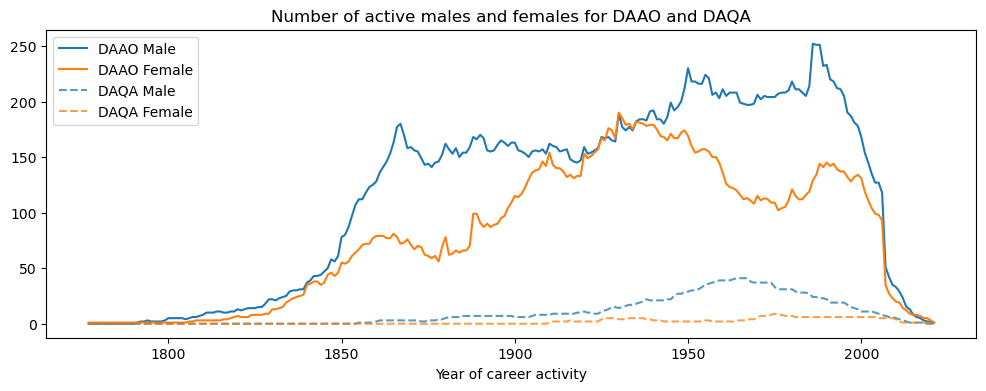

In [418]:
# persons = fetch_data(acdedata='person')
# daao_daqa = persons[persons.data_source.str.contains('DAQA|DAAO')][['gender', 'data_source', 'birth','death','career']]
# daao_daqa = daao_daqa[daao_daqa['career'].notnull()]

# selected_idx = []
# selected_birth_year = [] 
# selected_start_year = []
# selected_end_year = []
# selected_death_year = []

# for idx,row in daao_daqa.iterrows():
#     try: selected_birth_year.append(int(pd.json_normalize(json.loads(row['birth']))['coverage.date.year'].values[0]))
#     except: selected_birth_year.append(np.nan)

#     try:
#         career_df = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'].values[0])
#         selected_start_year.append(career_df['coverage_range.date_range.date_start.year'].min())
#     except: selected_start_year.append(np.nan)

#     try:
#         career_df = pd.json_normalize(pd.json_normalize(json.loads(row['career']))['career_periods'].values[0])
#         selected_end_year.append(career_df['coverage_range.date_range.date_end.year'].max())
#     except: selected_end_year.append(np.nan)

#     try: selected_death_year.append(int(pd.json_normalize(json.loads(row['death']))['coverage.date.year'].values[0]))
#     except: selected_death_year.append(np.nan)

# # daao_daqa = daao_daqa[daao_daqa.index.isin(selected_idx)].copy()
# daao_daqa['birth_year'] = selected_birth_year
# daao_daqa['career_start'] = selected_start_year
# # return max year of selected_end_year and death_year, there may be nan values
# daao_daqa['career_end'] = selected_end_year
# daao_daqa['death_year'] = selected_start_year

# # manipulate career_start so that each value contains the first 4 digits
# daao_daqa['career_start'] = daao_daqa['career_start'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])
# daao_daqa['career_end'] = daao_daqa['career_end'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])
# daao_daqa['death_year'] = daao_daqa['death_year'].apply(lambda x: np.nan if isinstance(x,float) else str(x)[:4])

# # change all strings that are not numbers to nan
# daao_daqa['career_start'] = daao_daqa['career_start'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
# daao_daqa['career_end'] = daao_daqa['career_end'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
# daao_daqa['death_year'] = daao_daqa['death_year'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

# daao_daqa['gender'] = daao_daqa['gender'].apply(lambda x: str(x.replace('"', '')))
# daao_daqa['data_source'] = daao_daqa['data_source'].apply(lambda x: str(x.replace('"', '')))
# daao_daqa = daao_daqa[daao_daqa['gender']\
#     .str.contains('male|female')][['gender','data_source','birth_year','death_year','career_start','career_end']]

# daao_daqa = daao_daqa[(daao_daqa.death_year.notnull()) | (daao_daqa.career_end.notnull())].copy()
# daao_daqa['career_end'] = daao_daqa['career_end'].fillna(-1)
# daao_daqa['death_year'] = daao_daqa['death_year'].fillna(-1)
# daao_daqa['career_end'] = np.where(daao_daqa['career_end'] > daao_daqa['death_year'], daao_daqa['career_end'], daao_daqa['death_year'])

# daao_daqa = daao_daqa[daao_daqa['career_start'].notnull()][['gender','data_source','career_start','career_end']]
# daao_daqa = daao_daqa[daao_daqa['career_start'] != daao_daqa['career_end']]
# daao_daqa.reset_index(inplace=True, drop=True)

# daao_daqa_wide = pd.DataFrame()

# for i,row in daao_daqa.iterrows():
#     for year in range(int(row['career_start']), int(row['career_end'])+1): 
#         daao_daqa_wide.loc[i, year] = 1

# daao_daqa_wide = daao_daqa_wide.fillna(0)
# daao_daqa_wide = pd.merge(daao_daqa, daao_daqa_wide, left_index=True, right_index=True)

# daao_females_wide = daao_daqa_wide[(daao_daqa_wide.gender == 'female') & (daao_daqa_wide.data_source == 'DAAO')].copy()
# daao_males_wide = daao_daqa_wide[(daao_daqa_wide.gender == 'male') & (daao_daqa_wide.data_source == 'DAAO')].copy()
# daqa_females_wide = daao_daqa_wide[(daao_daqa_wide.gender == 'female') & (daao_daqa_wide.data_source == 'DAQA')].copy()
# daqa_males_wide = daao_daqa_wide[(daao_daqa_wide.gender == 'male') & (daao_daqa_wide.data_source == 'DAQA')].copy()

# daao_females_wide = daao_females_wide.drop(['gender','data_source','career_start','career_end'], axis=1)
# daao_males_wide = daao_males_wide.drop(['gender','data_source','career_start','career_end'], axis=1)

# daao_gender_count = pd.merge(daao_males_wide.sum().reset_index().sort_values('index', ascending=True),
#                             daao_females_wide.sum().reset_index().sort_values('index', ascending=True), 
#                             on='index', how='outer')

# daao_gender_count.columns = ['year','male','female']
# daao_gender_count['data_source'] = 'DAAO'

# daqa_females_wide = daqa_females_wide.drop(['gender','data_source','career_start','career_end'], axis=1)
# daqa_males_wide = daqa_males_wide.drop(['gender','data_source','career_start','career_end'], axis=1)

# daqa_gender_count = pd.merge(daqa_males_wide.sum().reset_index().sort_values('index', ascending=True),
#                             daqa_females_wide.sum().reset_index().sort_values('index', ascending=True), 
#                             on='index', how='outer')

# daqa_gender_count.columns = ['year','male','female']
# daqa_gender_count['data_source'] = 'DAQA'

# daqa_daao_gender_count = pd.concat([daao_gender_count, daqa_gender_count])

# daqa_daao_gender_count.to_csv('data/local/DAQA_gender_comparison.csv', index=False)

daqa_daao_gender_count = pd.read_csv('data/local/DAQA_gender_comparison.csv')

# plot
plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['male'], label='DAAO Male', color='tab:blue')

plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['female'], 
label='DAAO Female', color='tab:orange')

plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['male'], 
label='DAQA Male', color='tab:blue', alpha=0.75, linestyle='dashed')

plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['female'], 
label='DAQA Female', color='tab:orange', alpha=0.75, linestyle='dashed')

plt.title('Number of active males and females for DAAO and DAQA')
plt.xlabel('Year of career activity')

plt.legend()

# increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.show()

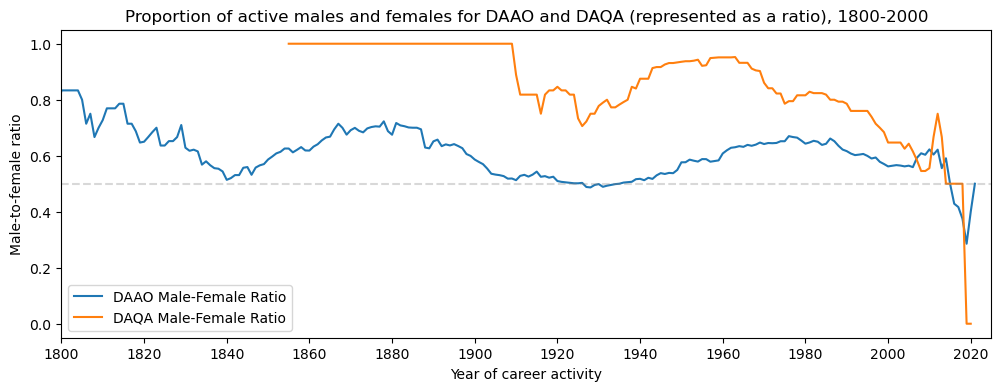

In [419]:
daqa_daao_gender_count['male_to_female'] = (daqa_daao_gender_count.male/(daqa_daao_gender_count.male + daqa_daao_gender_count.female))

# plot
plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAAO']['male_to_female'], label='DAAO Male-Female Ratio')

plt.plot(daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['year'], 
daqa_daao_gender_count[daqa_daao_gender_count.data_source == 'DAQA']['male_to_female'], label='DAQA Male-Female Ratio')

plt.title('Proportion of active males and females for DAAO and DAQA (represented as a ratio), 1800-2000')
plt.ylabel('Male-to-female ratio')
plt.xlabel('Year of career activity')

plt.legend()

# change x-axis limit
plt.xlim(1800, 2025)

# change x-axis tick frequency
plt.xticks(np.arange(1800, 2025, 20))

# add line at 50% mark
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.3)

# increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.show()